In [1]:
import sys
sys.path.insert(0, '../')
import os
from enum import Enum
import copy

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from scipy import interpolate
from scipy.signal import butter, sosfiltfilt, find_peaks
from utils import *


%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from scipy import stats
from sklearn.model_selection import KFold

torch.manual_seed(199711)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__config__.show())
print(f'PyTorch is running on {device}')

PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /w /bigobj /FS -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_FBGEMM -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE, LAPACK_INFO=mkl, PERF_WITH_AVX=1, PERF_WITH_AVX2=1, PERF_WITH_AVX512=1, TORCH_DISABLE_GPU_ASSERTS=OFF, TORCH_VERSION=2.0.1, USE_CUDA=0, USE_CUDNN=OFF, USE_EXCEPTION_PTR=1, USE_GFLAGS=OFF, USE_GLOG=OFF, USE_MKL=ON, USE_MKLDNN=ON, USE_MPI=OFF, USE_NCCL=OFF, USE_NNPACK=OFF, USE_OPENMP=ON, USE_ROCM=OFF, 

PyTorch is running 

___
**PREPROCESSING**

In [2]:
directory = '../dataset/tano'
filenames = [filename for filename in os.listdir(directory) if filename.endswith('.csv')]
labels = [filename.split('.')[0] for filename in filenames]
labels

['deep_breath',
 'dry_cough',
 'jumping_jack',
 'push_up',
 'random',
 'swallowing',
 'throat_clearing']

In [3]:
class Label(Enum):
    DEEP_BREATH = 0
    SWALLOWING = 1
    DRY_COUGH = 2
    THROAT_CLEARING = 3
    JUMPING_JACK = 4
    PUSH_UP = 5

# Visualizing preprocess

In [4]:
nirs_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
colors = nirs_color + or_color

dry_cough.csv


(0.3, 0.9)

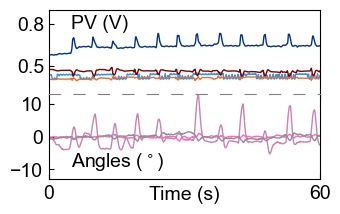

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.5, 2.2))
fig.subplots_adjust(hspace=0)

# Load
filename = filenames[1]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
p = detrend(p, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version
timestamps = timestamps / 1000

ax1.set_xlim([0, 60])
# ax1.set_ylabel('PV\n(V)')
ax1.text(5, 0.8, 'PV (V)', va='center')
ax1.spines['bottom'].set_visible(False)
ax1.set_yticks([0.5, 0.8])
ax1.tick_params(axis='y', direction='in', pad=3)

# ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)', labelpad=-12)
ax2.text(5, -8, 'Angles ($^\circ$)', va='center')
ax2.spines['top'].set_linestyle((0, (10, 12)))
ax2.spines['top'].set_color('gray')
ax2.set_xticks(np.linspace(0, 60, 2))
ax2.tick_params(axis='both', direction='in', pad=4)
ax2.set_ylim([-13, 13])

for idx in range(7):
    if idx <= 3:
        ax1.plot(timestamps, data[:, idx], c=colors[idx])
    else:
        ax2.plot(timestamps, data[:, idx], c=colors[idx])
ax1.set_ylim([0.3, 0.9])

# plt.savefig('../results/fig2/preprocessing_steps/preprocessing_steps_1.png',
#             dpi=600, bbox_inches='tight')

In [6]:
np.save('sample_data.npy', np.c)

(124101, 7)

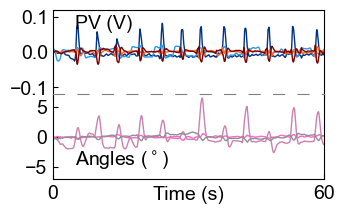

In [69]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.5, 2.2))
fig.subplots_adjust(hspace=0)

# Butterworth
sos = butter(2, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(3, 1, 'lowpass', output='sos', fs=1000)
data[:, 1] = sosfiltfilt(sos, data[:, 1], axis=0)

sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0) / 2

# subfig = subfigs.flatten()[1]
# (ax1, ax2) = subfig.subplots(nrows=2, sharex=True)

ax1.set_xlim([0, 60])
# ax1.set_ylabel('PV\n(V)')
ax1.text(5, 0.08, 'PV (V)', va='center')
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='y', direction='in', pad=3)
ax1.set_ylim([-0.12, 0.12])

# ax2.set_ylabel('Angles\n($\circ$)')\
ax2.set_xlabel('Time (s)', labelpad=-12)
ax2.text(5, -4, 'Angles ($^\circ$)', va='center')
ax2.spines['top'].set_linestyle((0, (10, 12)))
ax2.spines['top'].set_color('gray')
ax2.set_xticks(np.linspace(0, 60, 2))
ax2.tick_params(axis='both', direction='in', pad=4)
ax2.set_ylim([-7, 7])

for idx in range(7):
    if idx <= 3:
        ax1.plot(timestamps, data[:, idx], c=colors[idx])
    else:
        ax2.plot(timestamps, data[:, idx], c=colors[idx])

plt.savefig('../results/fig2/preprocessing_steps/preprocessing_steps_2.png',
            dpi=600, bbox_inches='tight')

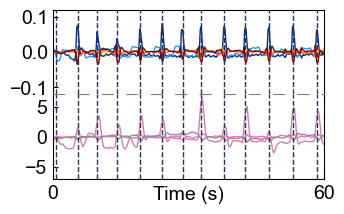

In [70]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.5, 2.2))
fig.subplots_adjust(hspace=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)

# subfig = subfigs.flatten()[2]
# (ax1, ax2) = subfig.subplots(nrows=2, sharex=True)

ax1.set_xlim([0, 60])
# ax1.set_ylabel('PV\n(V)')
# ax1.text(5, 0.08, 'PV (V)', va='center')
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='y', direction='in', pad=3)
ax1.set_ylim([-0.12, 0.12])

# ax2.set_ylabel('Angles\n($\circ$)')
# ax2.text(5, -4, 'Angles ($^\circ$)', va='center')
ax2.set_xlabel('Time (s)', labelpad=-12)
ax2.spines['top'].set_linestyle((0, (10, 12)))
ax2.spines['top'].set_color('gray')
ax2.set_xticks(np.linspace(0, 60, 2))
ax2.tick_params(axis='both', direction='in', pad=4)
ax2.set_ylim([-7, 7])

for idx in range(7):
    if idx <= 3:
        ax1.plot(timestamps, data[:, idx], c=colors[idx])
    else:
        ax2.plot(timestamps, data[:, idx], c=colors[idx])
for ax in fig.get_axes():
    ax.vlines(timestamps[peaks], 
              ax.get_ylim()[0],
              ax.get_ylim()[1],
              colors='#2D3250',
              linestyles='dashed')

plt.savefig('../results/fig2/preprocessing_steps/preprocessing_steps_3.png',
            dpi=600, bbox_inches='tight')

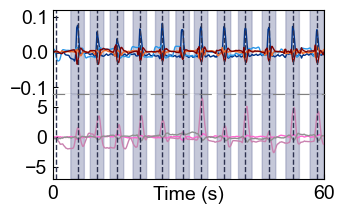

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3.5, 2.2))
fig.subplots_adjust(hspace=0)

# Construct slices
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_1 = []
for idx in range(expanded_peaks.shape[0]):
    slices_1.append(data[expanded_peaks[idx, :]])
slices_1 = np.array(slices_1)

# subfig = subfigs.flatten()[3]
# (ax1, ax2) = subfig.subplots(nrows=2, sharex=True)

ax1.set_xlim([0, 60])
# ax1.set_ylabel('PV\n(V)')
ax1.tick_params(axis='y', direction='in', pad=3)
ax1.set_ylim([-0.12, 0.12])

# ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)', labelpad=-12)
ax2.spines['top'].set_linestyle((0, (10, 12)))
ax2.spines['top'].set_color('gray')
ax2.set_xticks(np.linspace(0, 60, 2))
ax2.tick_params(axis='both', direction='in', pad=4)
# ax2.set_xlabel('Time (s)')
ax2.set_ylim([-7, 7])

for idx in range(7):
    if idx <= 3:
        ax1.plot(timestamps, data[:, idx], c=colors[idx])
    else:
        ax2.plot(timestamps, data[:, idx], c=colors[idx])

for ax in fig.get_axes():
    ax.vlines(timestamps[peaks], 
              ax.get_ylim()[0],
              ax.get_ylim()[1],
              colors='#2D3250',
              linestyles='dashed')
    ax.fill_between(timestamps,
                    ax.get_ylim()[0],
                    ax.get_ylim()[1],
                    where=np.in1d(np.arange(len(timestamps)), expanded_peaks),
                    color='#7077A1',
                    alpha=0.4)
    
plt.savefig('../results/fig2/preprocessing_steps/preprocessing_steps_4.png',
            dpi=600, bbox_inches='tight')

BREATH

deep_breath.csv
torch.Size([14, 1])
torch.Size([14, 7, 3000])


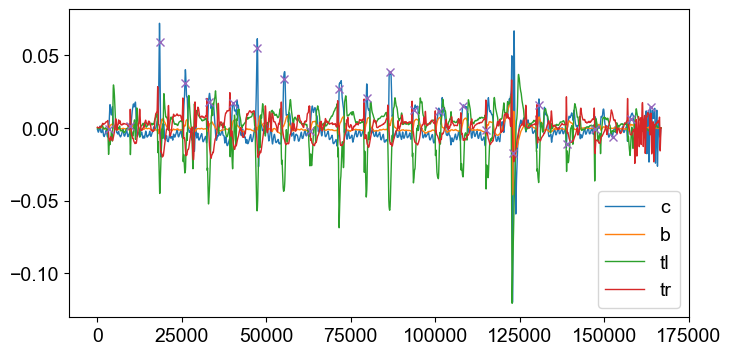

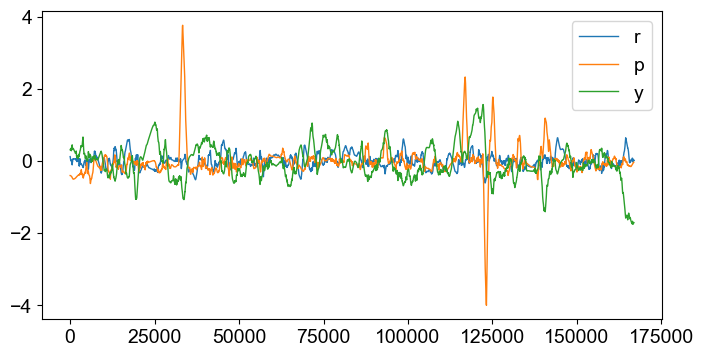

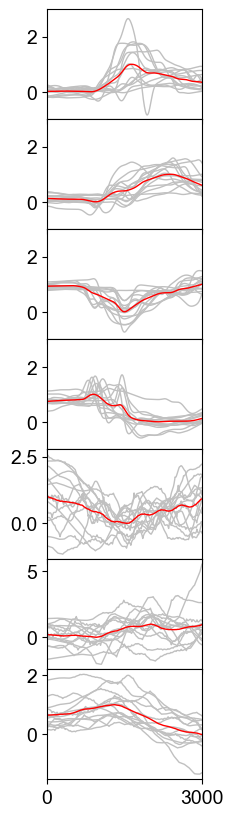

In [11]:
# deep breath
# Load
filename = filenames[0]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
p = detrend(p, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(-data[:, 2], distance=5000) # NOTE: Choose from seven channels to get the best result
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.legend(['r', 'p', 'y'])

# Construct slices_0
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_0 = []
for idx in range(expanded_peaks.shape[0]):
    slices_0.append(data[expanded_peaks[idx, :]])
slices_0 = np.array(slices_0)

# Create mask to filter outliers
# TODO: it should be easier to do the transpose -> (1, 0, 2) for all
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_0,
                                                                            (1, 0, 2))]),
              axis=0)
slices_0 = slices_0[mask.astype(bool), :, :]
slices_0 = torch.tensor(np.transpose(slices_0, (0, 2, 1)))
labels_0 = torch.broadcast_to(torch.tensor(Label.DEEP_BREATH.value), (slices_0.shape[0], 1))
print(labels_0.shape)
print(slices_0.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_0, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_0)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_0.shape[1]):
    slices_normalized[:, ch, :] = (slices_0[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_0 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_0.shape[0]):
        ax.plot(slices_0[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

dry_cough.csv
torch.Size([18, 1])
torch.Size([18, 7, 3000])


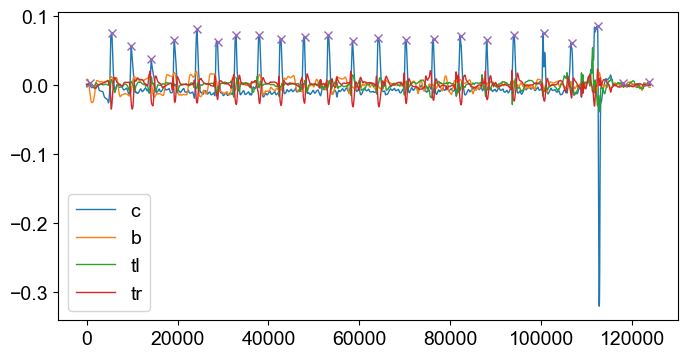

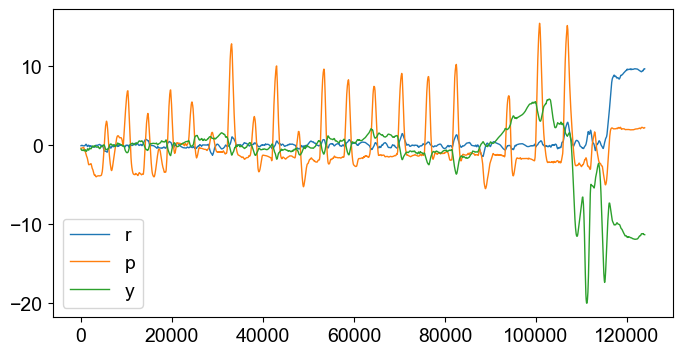

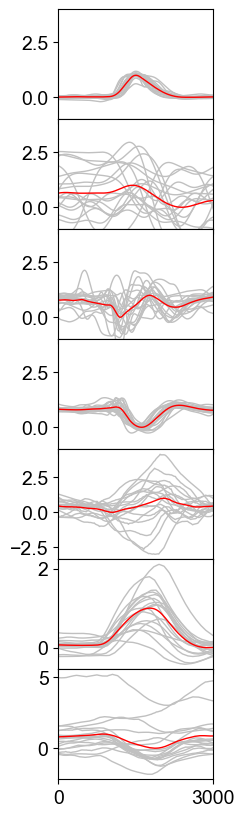

In [12]:
# dry cough
# Load
filename = filenames[1]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
p = detrend(p, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(2, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(3, 1, 'lowpass', output='sos', fs=1000)
data[:, 1] = sosfiltfilt(sos, data[:, 1], axis=0)

sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.legend(['r', 'p', 'y'])

# Construct slices
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_1 = []
for idx in range(expanded_peaks.shape[0]):
    slices_1.append(data[expanded_peaks[idx, :]])
slices_1 = np.array(slices_1)

# Create mask to filter outliers
# TODO: it should be easier to do the transpose -> (1, 0, 2) for all
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_1,
                                                                            (1, 0, 2))]),
              axis=0)
slices_1 = slices_1[mask.astype(bool), :, :]
slices_1 = torch.tensor(np.transpose(slices_1, (0, 2, 1)))
labels_1 = torch.broadcast_to(torch.tensor(Label.DRY_COUGH.value), (slices_1.shape[0], 1))
print(labels_1.shape)
print(slices_1.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_1, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_1)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_1.shape[1]):
    slices_normalized[:, ch, :] = (slices_1[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_1 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_1.shape[0]):
        ax.plot(slices_1[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 4)
plt.show()

jumping_jack.csv
torch.Size([10, 1])
torch.Size([10, 7, 3000])


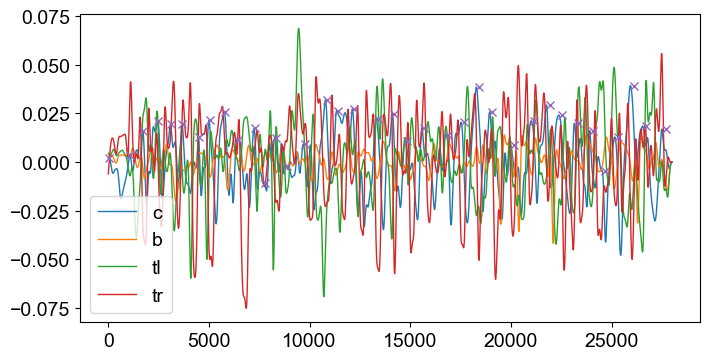

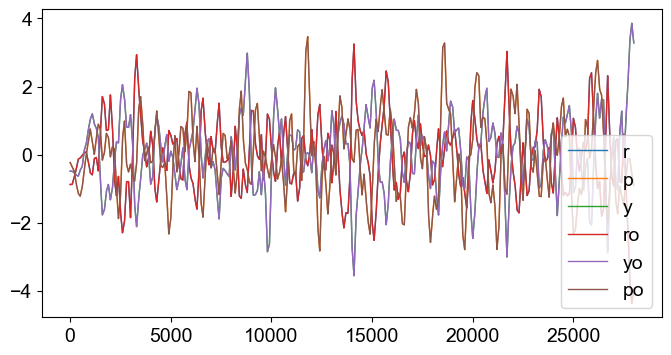

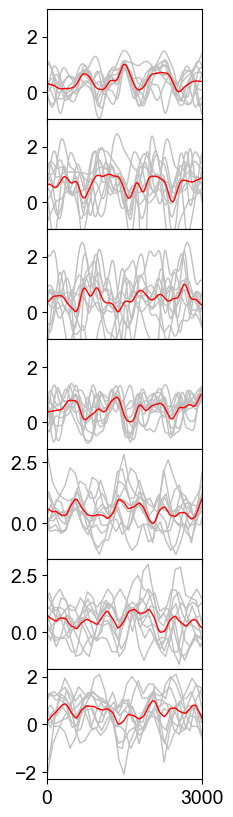

In [25]:
# jumping_jack
# Load
filename = filenames[2]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
data_raw = data_raw.truncate(after=280)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
r = detrend(r, method='butter', fc=50)
y = detrend(y, method='butter', fc=50)
p = detrend(p, method='butter', fc=50)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)

_, r = upsample(timestamps, r, ratio=100)
_, y = upsample(timestamps, y, ratio=100)
_, p = upsample(timestamps, p, ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
# sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
# data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:], label=['r', 'p', 'y'])
plt.plot(timestamps, r, label='ro')
plt.plot(timestamps, y, label='yo')
plt.plot(timestamps, p, label='po')
plt.legend()

# Construct slices
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_2 = []
for idx in range(expanded_peaks.shape[0]):
    slices_2.append(data[expanded_peaks[idx, :]])
slices_2 = np.array(slices_2)

# Create mask to filter outliers
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_2,
                                                                            (1, 0, 2))]),
              axis=0)
slices_2 = slices_2[mask.astype(bool), :, :]
slices_2 = torch.tensor(np.transpose(slices_2, (0, 2, 1)))
labels_2 = torch.broadcast_to(torch.tensor(Label.JUMPING_JACK.value), (slices_2.shape[0], 1))
print(labels_2.shape)
print(slices_2.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_2, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_2)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_2.shape[1]):
    slices_normalized[:, ch, :] = (slices_2[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_2 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_2.shape[0]):
        ax.plot(slices_2[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

swallowing.csv
torch.Size([14, 1])
torch.Size([14, 7, 3000])


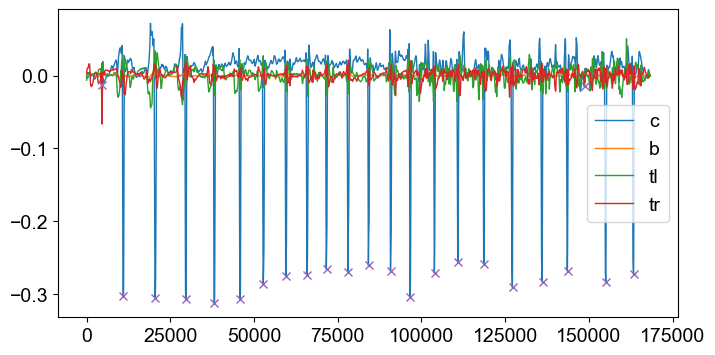

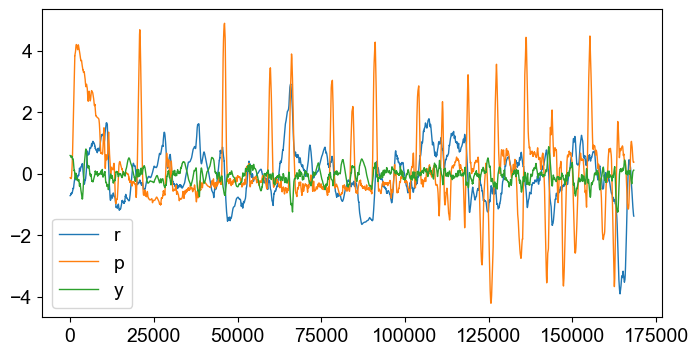

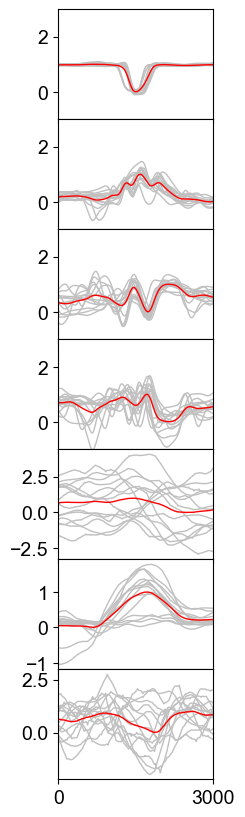

In [22]:
# swallowing
# Load
filename = filenames[5]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
p = detrend(p, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, y, p, r])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(-data[:, 0], distance=5000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.legend(['r', 'p', 'y'])

# Construct slices_3
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_3 = []
for idx in range(expanded_peaks.shape[0]):
    slices_3.append(data[expanded_peaks[idx, :]])
slices_3 = np.array(slices_3)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_3,
                                                                            (1, 0, 2))]),
              axis=0)
slices_3 = slices_3[mask.astype(bool), :, :]
slices_3 = torch.tensor(np.transpose(slices_3, (0, 2, 1)))
labels_3 = torch.broadcast_to(torch.tensor(Label.SWALLOWING.value), (slices_3.shape[0], 1))
print(labels_3.shape)
print(slices_3.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_3, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_3)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_3.shape[1]):
    slices_normalized[:, ch, :] = (slices_3[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_3 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_3.shape[0]):
        ax.plot(slices_3[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

push_up.csv
torch.Size([19, 1])
torch.Size([19, 7, 3000])


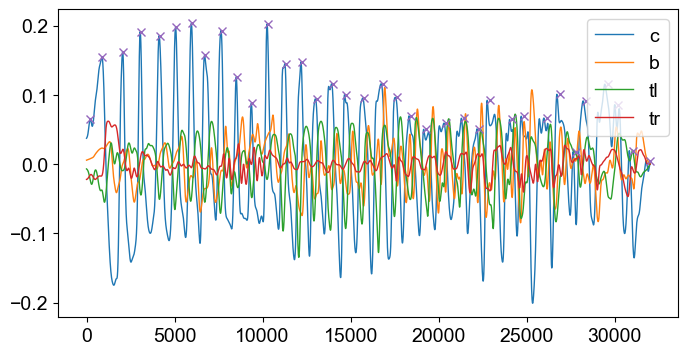

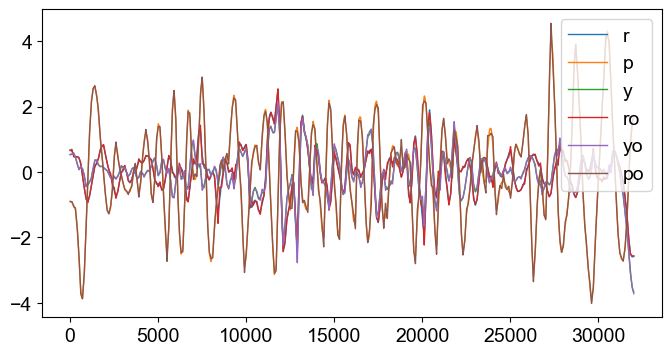

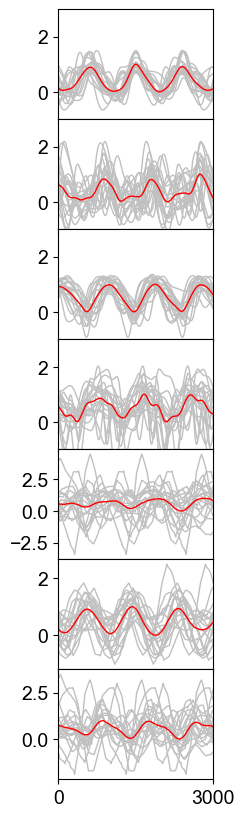

In [21]:
# push up
# Load
filename = filenames[3]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
data_raw = data_raw.truncate(after=320)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
r = detrend(r, method='butter', fc=50)
y = detrend(y, method='butter', fc=50)
p = detrend(p, method='butter', fc=50)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)

_, r = upsample(timestamps, r, ratio=100)
_, y = upsample(timestamps, y, ratio=100)
_, p = upsample(timestamps, p, ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:], label=['r', 'p', 'y'])
plt.plot(timestamps, r, label='ro')
plt.plot(timestamps, y, label='yo')
plt.plot(timestamps, p, label='po')
plt.legend()

# Construct slices
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_4 = []
for idx in range(expanded_peaks.shape[0]):
    slices_4.append(data[expanded_peaks[idx, :]])
slices_4 = np.array(slices_4)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_4,
                                                                            (1, 0, 2))]),
              axis=0)
slices_4 = slices_4[mask.astype(bool), :, :]
slices_4 = torch.tensor(np.transpose(slices_4, (0, 2, 1)))
labels_4 = torch.broadcast_to(torch.tensor(Label.PUSH_UP.value), (slices_4.shape[0], 1))
print(labels_4.shape)
print(slices_4.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_4, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_4)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_4.shape[1]):
    slices_normalized[:, ch, :] = (slices_4[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_4 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_4.shape[0]):
        ax.plot(slices_4[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

throat_clearing.csv
torch.Size([17, 1])
torch.Size([17, 7, 3000])


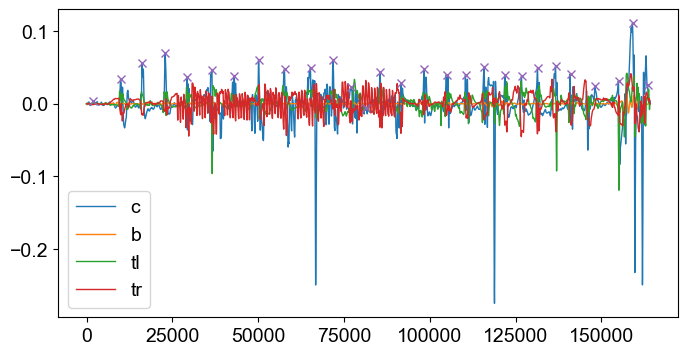

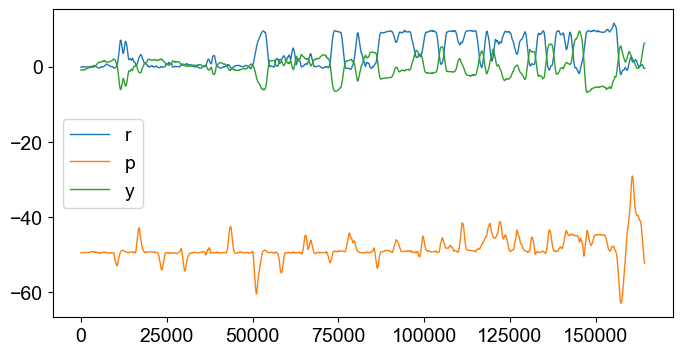

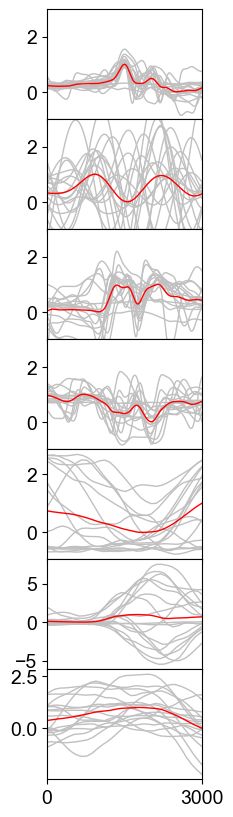

In [18]:
# throat clearing
# Load
filename = filenames[6]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(3, [0.5, 1], 'bandpass', output='sos', fs=1000)
data[:, 1] = sosfiltfilt(sos, data[:, 1], axis=0)

sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.legend(['r', 'p', 'y'])


# Construct slices_5
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_5 = []
for idx in range(expanded_peaks.shape[0]):
    slices_5.append(data[expanded_peaks[idx, :]])
slices_5 = np.array(slices_5)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_5,
                                                                            (1, 0, 2))]),
              axis=0)
slices_5 = slices_5[mask.astype(bool), :, :]
slices_5 = torch.tensor(np.transpose(slices_5, (0, 2, 1)))
labels_5 = torch.broadcast_to(torch.tensor(Label.THROAT_CLEARING.value), (slices_5.shape[0], 1))
print(labels_5.shape)
print(slices_5.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_5, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_5)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_5.shape[1]):
    slices_normalized[:, ch, :] = (slices_5[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_5 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_5.shape[0]):
        ax.plot(slices_5[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

___
**Data plotting**

In [26]:
all_slices = torch.cat((slices_0, slices_1, slices_2, slices_3, slices_4, slices_5), dim=0)
all_labels = torch.cat((labels_0, labels_1, labels_2, labels_3, labels_4, labels_5), dim=0)
print(all_slices.shape)
print(all_labels.shape)

torch.Size([92, 7, 3000])
torch.Size([92, 1])


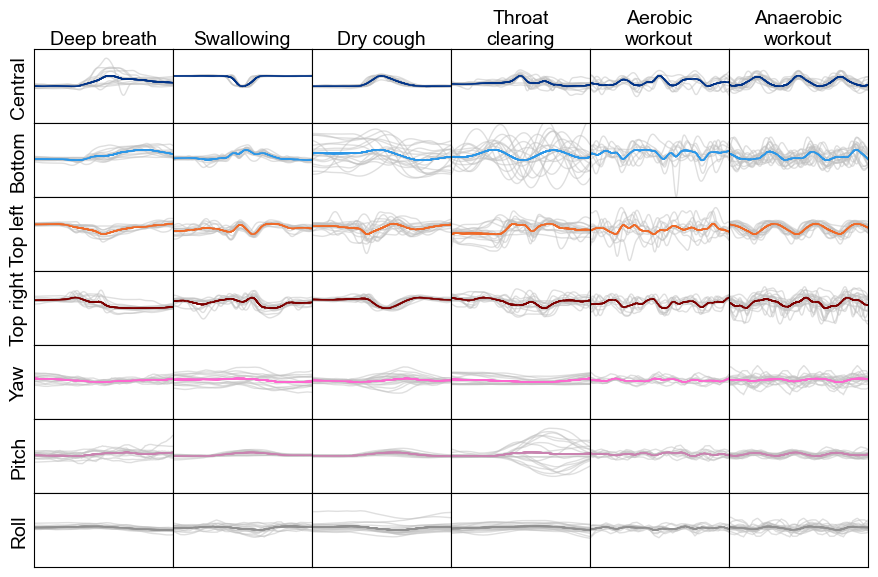

In [29]:
sensors = ['Central',
           'Bottom',
           'Top left',
           'Top right',
           'Yaw',
           'Pitch',
           'Roll']

labels = ['Deep breath',
          'Swallowing',
          'Dry cough',
          'Throat\nclearing',
          'Aerobic\nworkout',
          'Anaerobic\nworkout']

pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
colors = pv_color + or_color

fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(9, 6))

# Number of classes
n_channels = all_slices.shape[1]
n_classes = 6

# Iterate over each channel
for channel in range(n_channels):
    for class_code in range(n_classes):
        ax = axes[channel, class_code]
        class_samples = all_slices[all_labels.squeeze() == class_code]
        mean_data = class_samples.mean(dim=0)[channel]
        for sample in class_samples:
            ax.plot(sample[channel], alpha=0.5, color='silver')
            ax.plot(mean_data, color=colors[channel])

        if channel < 4:
            ax.set_ylim(-3.5, 3.5)
            ax.set_yticks([])
        else:
            ax.set_ylim(-10, 10)
            ax.set_yticks([])

        if class_code != 0:
            ax.set_yticks([])
        else:
            ax.set_ylabel(sensors[channel])

        if channel == 0:
            ax.set_xlabel(labels[class_code])
            ax.xaxis.set_label_position('top') 

        ax.set_xlim(0, 3000)
        ax.set_xticks([])
        
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig('../results/fig2/preprocessed/all.png', bbox_inches='tight', dpi=600)
plt.show()

___
**Dataset forming**

In [ ]:
all_slices = torch.cat((slices_0, slices_1, slices_2, slices_3, slices_4, slices_5), dim=0)
all_labels = torch.cat((labels_0, labels_1, labels_2, labels_3, labels_4, labels_5), dim=0)
print(all_slices.shape)
print(all_labels.shape)

In [4]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

class LHMPVBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, :4, :].transpose(0, 1).float(), self.labels[idx]

# new name
class LHMNIRSBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, :4, :].transpose(0, 1).float(), self.labels[idx]

class LHMIMUBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, 4:, :].transpose(0, 1).float(), self.labels[idx]

class LHMMonoDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, ...].transpose(0, 1).float(), self.labels[idx]

class LHMDualDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        photovoltage_data = self.features[idx, :4, :].float().transpose(0, 1)  # First 4 channels
        euler_angle_data = self.features[idx, 4:, :].float().transpose(0, 1)  # Last 3 channels
        return photovoltage_data, euler_angle_data, self.labels[idx]

In [ ]:
pv_biased_ds = LHMNIRSBiasedDataset(all_slices, all_labels)
torch.save(pv_biased_ds, '../dataset/preprocessed/pv_biased.pt')

imu_biased_ds = LHMIMUBiasedDataset(all_slices, all_labels)
torch.save(imu_biased_ds, '../dataset/preprocessed/imu_biased.pt')

mono_ds = LHMMonoDataset(all_slices, all_labels)
torch.save(mono_ds, '../dataset/preprocessed/mono.pt')

dual_ds = LHMDualDataset(all_slices, all_labels)
torch.save(dual_ds, '../dataset/preprocessed/dual.pt')

___
**Training**

In [5]:
nirs_biased_ds = torch.load('../dataset/preprocessed/pv_biased.pt')
imu_biased_ds = torch.load('../dataset/preprocessed/imu_biased.pt')
mono_ds = torch.load('../dataset/preprocessed/mono.pt')
dual_ds = torch.load('../dataset/preprocessed/dual.pt')

print(dual_ds.features.shape)
print(dual_ds.labels.shape)

torch.Size([99, 7, 3000])
torch.Size([99, 1])


RNN model definitions

In [6]:
class BaseRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BaseRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        num_directions = 2 if self.rnn.bidirectional else 1
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, hn = self.rnn(x, h0.detach()) # hn, cn are here as placeholder
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out
    
class NIRSBiasedRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(NIRSBiasedRNNModel, self).__init__(4, hidden_dim, layer_dim, output_dim)

class NIRSBiasedBiRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(NIRSBiasedBiRNNModel, self).__init__(4, hidden_dim, layer_dim, output_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class IMUBiasedRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedRNNModel, self).__init__(3, hidden_dim, layer_dim, output_dim)

class IMUBiasedBiRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedBiRNNModel, self).__init__(3, hidden_dim, layer_dim, output_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class MonoRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoRNNModel, self).__init__(7, hidden_dim, layer_dim, output_dim)

class MonoBiRNNModel(BaseRNNModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoBiRNNModel, self).__init__(7, hidden_dim, layer_dim, output_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class DualRNNModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn1 = nn.RNN(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.rnn2 = nn.RNN(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states for both RNNs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.rnn1(x1, h01.detach())
        out2, _ = self.rnn2(x2, h02.detach())

        # Concatenate the outputs from both RNNs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out
    
class DualBiRNNModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualBiRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout_prob = dropout_prob

        self.rnn1 = nn.RNN(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.rnn2 = nn.RNN(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.rnn1(x1, h01.detach())
        out2, _ = self.rnn2(x2, h02.detach())

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

LSTM model definitions

In [7]:
class BaseLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BaseLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        num_directions = 2 if self.lstm.bidirectional else 1
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # hn, cn are here as placeholder
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

class NIRSBiasedLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(NIRSBiasedLSTMModel, self).__init__(4, hidden_dim, layer_dim, output_dim)

class NIRSBiasedBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(NIRSBiasedBiLSTMModel, self).__init__(4, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class IMUBiasedLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedLSTMModel, self).__init__(3, hidden_dim, layer_dim, output_dim)

class IMUBiasedBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedBiLSTMModel, self).__init__(3, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class MonoLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoLSTMModel, self).__init__(7, hidden_dim, layer_dim, output_dim)

class MonoBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoBiLSTMModel, self).__init__(7, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class DualLSTMModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout_prob = dropout_prob

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.lstm1(x1, (h01.detach(), c01.detach()))
        out2, _ = self.lstm2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

class DualBiLSTMModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualBiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout_prob = dropout_prob

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.lstm1(x1, (h01.detach(), c01.detach()))
        out2, _ = self.lstm2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

GRU model definitions

In [8]:
class BaseGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BaseGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        num_directions = 2 if self.gru.bidirectional else 1
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, hn = self.gru(x, (h0.detach())) # hn, cn are here as placeholder
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

class NIRSBiasedGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(NIRSBiasedGRUModel, self).__init__(4, hidden_dim, layer_dim, output_dim)

class NIRSBiasedBiGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(NIRSBiasedBiGRUModel, self).__init__(4, hidden_dim, layer_dim, output_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class IMUBiasedGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedGRUModel, self).__init__(3, hidden_dim, layer_dim, output_dim)

class IMUBiasedBiGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedBiGRUModel, self).__init__(3, hidden_dim, layer_dim, output_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class MonoGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoGRUModel, self).__init__(7, hidden_dim, layer_dim, output_dim)

class MonoBiGRUModel(BaseGRUModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoBiGRUModel, self).__init__(7, hidden_dim, layer_dim, output_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class DualGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states for both GRUs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.gru1(x1, h01.detach())
        out2, _ = self.gru2(x2, h02.detach())

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out
    
class DualBiGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualBiGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 4, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states for both GRUs
        h01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.gru1(x1, h01.detach())
        out2, _ = self.gru2(x2, h02.detach())

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

Hyperparameters and dataset definitions

In [9]:
input_dim1 = 4 # For nirs data
input_dim2 = 3 # For Euler angle data
hidden_dim = 140
layer_dim = 1
output_dim = 6 # Number of classes
dropout_prob = 0

num_epochs = 400

# Number of folds for cross-validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
dataset_indices = list(range(len(dual_ds)))

# Preparing data
batch_size = 32

total_samples = len(nirs_biased_ds)
test_size = int(0.3 * total_samples)
train_size = total_samples - test_size

In [218]:
train_dataset_nirs_biased, test_dataset_nirs_biased = random_split(nirs_biased_ds, [train_size, test_size])
train_loader_nirs_biased = DataLoader(train_dataset_nirs_biased, batch_size=batch_size, shuffle=True)
test_loader_nirs_biased = DataLoader(test_dataset_nirs_biased, batch_size=batch_size, shuffle=False)

train_dataset_nirs_biased_bi, test_dataset_nirs_biased_bi = random_split(nirs_biased_ds, [train_size, test_size])
train_loader_nirs_biased_bi = DataLoader(train_dataset_nirs_biased_bi, batch_size=batch_size, shuffle=True)
test_loader_nirs_biased_bi = DataLoader(test_dataset_nirs_biased_bi, batch_size=batch_size, shuffle=False)

train_dataset_imu_biased, test_dataset_imu_biased = random_split(imu_biased_ds, [train_size, test_size])
train_loader_imu_biased = DataLoader(train_dataset_imu_biased, batch_size=batch_size, shuffle=True)
test_loader_imu_biased = DataLoader(test_dataset_imu_biased, batch_size=batch_size, shuffle=False)

train_dataset_imu_biased_bi, test_dataset_imu_biased_bi = random_split(imu_biased_ds, [train_size, test_size])
train_loader_imu_biased_bi = DataLoader(train_dataset_imu_biased_bi, batch_size=batch_size, shuffle=True)
test_loader_imu_biased_bi = DataLoader(test_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)

train_dataset_mono, test_dataset_mono = random_split(mono_ds, [train_size, test_size])
train_loader_mono = DataLoader(train_dataset_mono, batch_size=batch_size, shuffle=True)
test_loader_mono = DataLoader(test_dataset_mono, batch_size=batch_size, shuffle=False)

train_dataset_mono_bi, test_dataset_mono_bi = random_split(mono_ds, [train_size, test_size])
train_loader_mono_bi = DataLoader(train_dataset_mono_bi, batch_size=batch_size, shuffle=True)
test_loader_mono_bi = DataLoader(test_dataset_mono_bi, batch_size=batch_size, shuffle=False)

train_dataset_dual, test_dataset_dual = random_split(dual_ds, [train_size, test_size])
train_loader_dual = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=True)
test_loader_dual = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)

train_dataset_dual_bi, test_dataset_dual_bi = random_split(dual_ds, [train_size, test_size])
train_loader_dual_bi = DataLoader(train_dataset_dual_bi, batch_size=batch_size, shuffle=True)
test_loader_dual_bi = DataLoader(test_dataset_dual_bi, batch_size=batch_size, shuffle=False)

**FRNN**

NIRS biased FRNN

In [10]:
# Container for losses and accuracies
train_losses_rnn_nirs_biased = [[] for _ in range(k)]
train_accuracies_rnn_nirs_biased = [[] for _ in range(k)]
test_losses_rnn_nirs_biased = [[] for _ in range(k)]
test_accuracies_rnn_nirs_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_nirs_biased = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_nirs_biased = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_nirs_biased = NIRSBiasedRNNModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_nirs_biased = torch.optim.Adam(model_rnn_nirs_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_nirs_biased.to(device))

    for epoch in range(num_epochs):
        model_rnn_nirs_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_nirs_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_nirs_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_nirs_biased.zero_grad()
            loss.backward()
            optimizer_nirs_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_nirs_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_nirs_biased[fold].append(avg_train_loss)
        train_accuracies_rnn_nirs_biased[fold].append(train_accuracy)

        model_rnn_nirs_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_nirs_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_nirs_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_nirs_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_nirs_biased[fold].append(avg_test_loss)
        test_accuracies_rnn_nirs_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
NIRSBiasedRNNModel(
  (rnn): RNN(4, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7756, Train Accuracy: 0.2532, Test Loss: 1.7780, Test Accuracy: 0.3500
Epoch [10/400], Train Loss: 1.7633, Train Accuracy: 0.2911, Test Loss: 1.7711, Test Accuracy: 0.3500
Epoch [15/400], Train Loss: 1.7483, Train Accuracy: 0.2785, Test Loss: 1.7636, Test Accuracy: 0.3000
Epoch [20/400], Train Loss: 1.7295, Train Accuracy: 0.2405, Test Loss: 1.7538, Test Accuracy: 0.2500
Epoch [25/400], Train Loss: 1.7105, Train Accuracy: 0.2405, Test Loss: 1.7429, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.6843, Train Accuracy: 0.2152, Test Loss: 1.7279, Test Accuracy: 0.2500
Epoch [35/400], Train Loss: 1.6353, Train Accuracy: 0.3291, Test Loss: 1.7023, Test Accuracy: 0.3500
Epoch [40/400], Train Loss: 1.5337, Train Accuracy: 0.4051, Test Loss: 1.6610, Test Accuracy: 0.2500


BiRNN PV Biased

In [11]:
# Container for losses and accuracies
train_losses_rnn_nirs_biased_bi = [[] for _ in range(k)]
train_accuracies_rnn_nirs_biased_bi = [[] for _ in range(k)]
test_losses_rnn_nirs_biased_bi = [[] for _ in range(k)]
test_accuracies_rnn_nirs_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_nirs_biased_bi = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_nirs_biased_bi = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsmapler)

    # Model definition
    model_rnn_nirs_biased_bi = NIRSBiasedBiRNNModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_nirs_biased_bi = torch.optim.Adam(model_rnn_nirs_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_nirs_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_rnn_nirs_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_nirs_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_nirs_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_nirs_biased_bi.zero_grad()
            loss.backward()
            optimizer_nirs_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_nirs_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_nirs_biased_bi[fold].append(avg_train_loss)
        train_accuracies_rnn_nirs_biased_bi[fold].append(train_accuracy)

        model_rnn_nirs_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_nirs_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_nirs_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_nirs_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_nirs_biased_bi[fold].append(avg_test_loss)
        test_accuracies_rnn_nirs_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
NIRSBiasedBiRNNModel(
  (rnn): RNN(4, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7899, Train Accuracy: 0.2278, Test Loss: 1.7906, Test Accuracy: 0.2405
Epoch [10/400], Train Loss: 1.7730, Train Accuracy: 0.3038, Test Loss: 1.7678, Test Accuracy: 0.3291
Epoch [15/400], Train Loss: 1.7512, Train Accuracy: 0.4557, Test Loss: 1.7539, Test Accuracy: 0.4051
Epoch [20/400], Train Loss: 1.7358, Train Accuracy: 0.4177, Test Loss: 1.7363, Test Accuracy: 0.4051
Epoch [25/400], Train Loss: 1.7141, Train Accuracy: 0.4304, Test Loss: 1.7060, Test Accuracy: 0.4430
Epoch [30/400], Train Loss: 1.6890, Train Accuracy: 0.4557, Test Loss: 1.6819, Test Accuracy: 0.4430
Epoch [35/400], Train Loss: 1.5888, Train Accuracy: 0.4051, Test Loss: 1.5571, Test Accuracy: 0.3797
Epoch [40/400], Train Loss: 1.4838, Train Accuracy: 0.3797, Test Loss: 1.5013, 

RNN IMU Biased

In [12]:
# Container for losses and accuracies
train_losses_rnn_imu_biased = [[] for _ in range(k)]
train_accuracies_rnn_imu_biased = [[] for _ in range(k)]
test_losses_rnn_imu_biased = [[] for _ in range(k)]
test_accuracies_rnn_imu_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_imu_biased = IMUBiasedRNNModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased = torch.optim.Adam(model_rnn_imu_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_imu_biased.to(device))

    for epoch in range(num_epochs):
        model_rnn_imu_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_imu_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased.zero_grad()
            loss.backward()
            optimizer_imu_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_imu_biased[fold].append(avg_train_loss)
        train_accuracies_rnn_imu_biased[fold].append(train_accuracy)

        model_rnn_imu_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_imu_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_imu_biased[fold].append(avg_test_loss)
        test_accuracies_rnn_imu_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
IMUBiasedRNNModel(
  (rnn): RNN(3, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7787, Train Accuracy: 0.1266, Test Loss: 1.8087, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7515, Train Accuracy: 0.1772, Test Loss: 1.8045, Test Accuracy: 0.1000
Epoch [15/400], Train Loss: 1.7576, Train Accuracy: 0.2152, Test Loss: 1.8018, Test Accuracy: 0.1000
Epoch [20/400], Train Loss: 1.7469, Train Accuracy: 0.2152, Test Loss: 1.8004, Test Accuracy: 0.1000
Epoch [25/400], Train Loss: 1.7364, Train Accuracy: 0.2152, Test Loss: 1.7992, Test Accuracy: 0.0500
Epoch [30/400], Train Loss: 1.7295, Train Accuracy: 0.2152, Test Loss: 1.7978, Test Accuracy: 0.1000
Epoch [35/400], Train Loss: 1.7208, Train Accuracy: 0.2025, Test Loss: 1.7977, Test Accuracy: 0.1000
Epoch [40/400], Train Loss: 1.7159, Train Accuracy: 0.2025, Test Loss: 1.7941, Test Accuracy: 0.1000
E

BiRNN IMU Biased

In [13]:
# Container for losses and accuracies
train_losses_rnn_imu_biased_bi = [[] for _ in range(k)]
train_accuracies_rnn_imu_biased_bi = [[] for _ in range(k)]
test_losses_rnn_imu_biased_bi = [[] for _ in range(k)]
test_accuracies_rnn_imu_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_imu_biased_bi = IMUBiasedBiRNNModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased_bi = torch.optim.Adam(model_rnn_imu_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_imu_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_rnn_imu_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_imu_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased_bi.zero_grad()
            loss.backward()
            optimizer_imu_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_imu_biased_bi[fold].append(avg_train_loss)
        train_accuracies_rnn_imu_biased_bi[fold].append(train_accuracy)

        model_rnn_imu_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_imu_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_imu_biased_bi[fold].append(avg_test_loss)
        test_accuracies_rnn_imu_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
IMUBiasedBiRNNModel(
  (rnn): RNN(3, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7933, Train Accuracy: 0.2152, Test Loss: 1.7798, Test Accuracy: 0.2500
Epoch [10/400], Train Loss: 1.7854, Train Accuracy: 0.3544, Test Loss: 1.7784, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7690, Train Accuracy: 0.3797, Test Loss: 1.7777, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7661, Train Accuracy: 0.3924, Test Loss: 1.7750, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7632, Train Accuracy: 0.3797, Test Loss: 1.7748, Test Accuracy: 0.1500
Epoch [30/400], Train Loss: 1.7521, Train Accuracy: 0.3671, Test Loss: 1.7757, Test Accuracy: 0.1500
Epoch [35/400], Train Loss: 1.7473, Train Accuracy: 0.3544, Test Loss: 1.7784, Test Accuracy: 0.2000
Epoch [40/400], Train Loss: 1.7339, Train Accuracy: 0.3165, Test Loss: 1.7766, T

RNN mono

In [14]:
# Container for losses and accuracies
train_losses_rnn_mono = [[] for _ in range(k)]
train_accuracies_rnn_mono = [[] for _ in range(k)]
test_losses_rnn_mono = [[] for _ in range(k)]
test_accuracies_rnn_mono = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_mono = MonoRNNModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono = torch.optim.Adam(model_rnn_mono.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_mono.to(device))

    for epoch in range(num_epochs):
        model_rnn_mono.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_mono(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono.zero_grad()
            loss.backward()
            optimizer_mono.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_mono[fold].append(avg_train_loss)
        train_accuracies_rnn_mono[fold].append(train_accuracy)

        model_rnn_mono.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_mono(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_mono[fold].append(avg_test_loss)
        test_accuracies_rnn_mono[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
MonoRNNModel(
  (rnn): RNN(7, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7675, Train Accuracy: 0.1646, Test Loss: 1.7887, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7498, Train Accuracy: 0.1899, Test Loss: 1.7815, Test Accuracy: 0.1000
Epoch [15/400], Train Loss: 1.7381, Train Accuracy: 0.2025, Test Loss: 1.7773, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7183, Train Accuracy: 0.2025, Test Loss: 1.7693, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7020, Train Accuracy: 0.2278, Test Loss: 1.7604, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.6954, Train Accuracy: 0.2532, Test Loss: 1.7526, Test Accuracy: 0.2500
Epoch [35/400], Train Loss: 1.6536, Train Accuracy: 0.3671, Test Loss: 1.7434, Test Accuracy: 0.4000
Epoch [40/400], Train Loss: 1.6358, Train Accuracy: 0.4684, Test Loss: 1.7306, Test Accuracy: 0.4000
Epoch 

BiRNN mono

In [15]:
# Container for losses and accuracies
train_losses_rnn_mono_bi = [[] for _ in range(k)]
train_accuracies_rnn_mono_bi = [[] for _ in range(k)]
test_losses_rnn_mono_bi = [[] for _ in range(k)]
test_accuracies_rnn_mono_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_mono_bi = MonoBiRNNModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono_bi = torch.optim.Adam(model_rnn_mono_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_rnn_mono_bi.to(device))

    for epoch in range(num_epochs):
        model_rnn_mono_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_mono_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono_bi.zero_grad()
            loss.backward()
            optimizer_mono_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_mono_bi[fold].append(avg_train_loss)
        train_accuracies_rnn_mono_bi[fold].append(train_accuracy)

        model_rnn_mono_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_mono_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_mono_bi[fold].append(avg_test_loss)
        test_accuracies_rnn_mono_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
MonoBiRNNModel(
  (rnn): RNN(7, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7911, Train Accuracy: 0.2152, Test Loss: 1.7821, Test Accuracy: 0.3000
Epoch [10/400], Train Loss: 1.7642, Train Accuracy: 0.2911, Test Loss: 1.7738, Test Accuracy: 0.3000
Epoch [15/400], Train Loss: 1.7459, Train Accuracy: 0.3291, Test Loss: 1.7689, Test Accuracy: 0.2500
Epoch [20/400], Train Loss: 1.7335, Train Accuracy: 0.3671, Test Loss: 1.7612, Test Accuracy: 0.2500
Epoch [25/400], Train Loss: 1.7064, Train Accuracy: 0.4051, Test Loss: 1.7537, Test Accuracy: 0.3000
Epoch [30/400], Train Loss: 1.6878, Train Accuracy: 0.4810, Test Loss: 1.7521, Test Accuracy: 0.3000
Epoch [35/400], Train Loss: 1.6844, Train Accuracy: 0.5063, Test Loss: 1.7511, Test Accuracy: 0.3000
Epoch [40/400], Train Loss: 1.6546, Train Accuracy: 0.5190, Test Loss: 1.7464, Test A

RNN dual

In [16]:
train_losses_rnn_dual = [[] for _ in range(k)]
train_accuracies_rnn_dual = [[] for _ in range(k)]
test_losses_rnn_dual = [[] for _ in range(k)]
test_accuracies_rnn_dual = [[] for _ in range(k)]

# best_accuracy = 0.0
# best_model_dual = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_dual = DualRNNModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer_dual = torch.optim.Adam(model_rnn_dual.parameters(), lr=0.0001, weight_decay=0.01)
    print(model_rnn_dual.to(device))

    for epoch in range(num_epochs):
        model_rnn_dual.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual.zero_grad()
            loss.backward()
            optimizer_dual.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_dual[fold].append(avg_train_loss)
        train_accuracies_rnn_dual[fold].append(train_accuracy)

        model_rnn_dual.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_dual(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_dual[fold].append(avg_test_loss)
        test_accuracies_rnn_dual[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    # fold_best_accuracy = max(test_accuracies_dual[fold])
    # if fold_best_accuracy > best_accuracy:
    #     best_accuracy = fold_best_accuracy
    #     best_model_dual = copy.deepcopy(model_dual)

---------------
In Fold 0
---------------
DualRNNModel(
  (rnn1): RNN(4, 140, batch_first=True)
  (rnn2): RNN(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7831, Train Accuracy: 0.2911, Test Loss: 1.8064, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7612, Train Accuracy: 0.4810, Test Loss: 1.7942, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7346, Train Accuracy: 0.4937, Test Loss: 1.7865, Test Accuracy: 0.3000
Epoch [20/400], Train Loss: 1.7130, Train Accuracy: 0.4304, Test Loss: 1.7779, Test Accuracy: 0.2500
Epoch [25/400], Train Loss: 1.6874, Train Accuracy: 0.4304, Test Loss: 1.7669, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.6404, Train Accuracy: 0.4684, Test Loss: 1.7497, Test Accuracy: 0.3000
Epoch [35/400], Train Loss: 1.5620, Train Accuracy: 0.4557, Test Loss: 1.7079, Test Accuracy: 0.3000
Epoch [40/400], Train Loss: 1.5818, Train Accuracy: 0.4304, Test L

BiRNN dual

In [17]:
# Container for losses and accuracies
train_losses_rnn_dual_bi = [[] for _ in range(k)]
train_accuracies_rnn_dual_bi = [[] for _ in range(k)]
test_losses_rnn_dual_bi = [[] for _ in range(k)]
test_accuracies_rnn_dual_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_rnn_dual_bi = DualBiRNNModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    print(model_rnn_dual_bi.to(device))

    criterion = nn.CrossEntropyLoss()
    optimizer_dual_bi = torch.optim.Adam(model_rnn_dual_bi.parameters(), lr=0.0001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_rnn_dual_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual_bi:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_rnn_dual_bi(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual_bi.zero_grad()
            loss.backward()
            optimizer_dual_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_rnn_dual_bi[fold].append(avg_train_loss)
        train_accuracies_rnn_dual_bi[fold].append(train_accuracy)

        model_rnn_dual_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual_bi:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_rnn_dual_bi(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_rnn_dual_bi[fold].append(avg_test_loss)
        test_accuracies_rnn_dual_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
DualBiRNNModel(
  (rnn1): RNN(4, 140, batch_first=True, bidirectional=True)
  (rnn2): RNN(3, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=560, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7789, Train Accuracy: 0.2278, Test Loss: 1.7870, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7543, Train Accuracy: 0.3165, Test Loss: 1.7772, Test Accuracy: 0.1000
Epoch [15/400], Train Loss: 1.7331, Train Accuracy: 0.3544, Test Loss: 1.7677, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7180, Train Accuracy: 0.3671, Test Loss: 1.7580, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.6761, Train Accuracy: 0.3671, Test Loss: 1.7438, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.6553, Train Accuracy: 0.4557, Test Loss: 1.7259, Test Accuracy: 0.2500
Epoch [35/400], Train Loss: 1.5951, Train Accuracy: 0.4684, Test Loss: 1.6875, Test Accuracy: 0.3000
Epoch [40/400], Train Lo

**LSTM**

LSTM PV biased

In [18]:
# Container for losses and accuracies
train_losses_lstm_nirs_biased = [[] for _ in range(k)]
train_accuracies_lstm_nirs_biased = [[] for _ in range(k)]
test_losses_lstm_nirs_biased = [[] for _ in range(k)]
test_accuracies_lstm_nirs_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_nirs_biased = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_nirs_biased = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_nirs_biased = NIRSBiasedLSTMModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_nirs_biased = torch.optim.Adam(model_lstm_nirs_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_nirs_biased.to(device))

    for epoch in range(num_epochs):
        model_lstm_nirs_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_nirs_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_nirs_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_nirs_biased.zero_grad()
            loss.backward()
            optimizer_nirs_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_nirs_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_nirs_biased[fold].append(avg_train_loss)
        train_accuracies_lstm_nirs_biased[fold].append(train_accuracy)

        model_lstm_nirs_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_nirs_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_nirs_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_nirs_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_nirs_biased[fold].append(avg_test_loss)
        test_accuracies_lstm_nirs_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
NIRSBiasedLSTMModel(
  (lstm): LSTM(4, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7972, Train Accuracy: 0.1266, Test Loss: 1.7881, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7965, Train Accuracy: 0.1392, Test Loss: 1.7860, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7892, Train Accuracy: 0.1266, Test Loss: 1.7838, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7871, Train Accuracy: 0.1646, Test Loss: 1.7818, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7831, Train Accuracy: 0.2025, Test Loss: 1.7800, Test Accuracy: 0.2500
Epoch [30/400], Train Loss: 1.7806, Train Accuracy: 0.3038, Test Loss: 1.7779, Test Accuracy: 0.2500
Epoch [35/400], Train Loss: 1.7742, Train Accuracy: 0.3038, Test Loss: 1.7760, Test Accuracy: 0.3000
Epoch [40/400], Train Loss: 1.7735, Train Accuracy: 0.3038, Test Loss: 1.7739, Test Accuracy: 0.25

BiLSTM NIRS biased

In [19]:
# Container for losses and accuracies
train_losses_lstm_nirs_biased_bi = [[] for _ in range(k)]
train_accuracies_lstm_nirs_biased_bi = [[] for _ in range(k)]
test_losses_lstm_nirs_biased_bi = [[] for _ in range(k)]
test_accuracies_lstm_nirs_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_nirs_biased_bi = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_nirs_biased_bi = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsmapler)

    # Model definition
    model_lstm_nirs_biased_bi = NIRSBiasedBiLSTMModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_nirs_biased_bi = torch.optim.Adam(model_lstm_nirs_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_nirs_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_lstm_nirs_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_nirs_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_nirs_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_nirs_biased_bi.zero_grad()
            loss.backward()
            optimizer_nirs_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_nirs_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_nirs_biased_bi[fold].append(avg_train_loss)
        train_accuracies_lstm_nirs_biased_bi[fold].append(train_accuracy)

        model_lstm_nirs_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_nirs_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_nirs_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_nirs_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_nirs_biased_bi[fold].append(avg_test_loss)
        test_accuracies_lstm_nirs_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
NIRSBiasedBiLSTMModel(
  (lstm): LSTM(4, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7805, Train Accuracy: 0.1772, Test Loss: 1.7827, Test Accuracy: 0.1772
Epoch [10/400], Train Loss: 1.7768, Train Accuracy: 0.1646, Test Loss: 1.7794, Test Accuracy: 0.1646
Epoch [15/400], Train Loss: 1.7699, Train Accuracy: 0.1519, Test Loss: 1.7786, Test Accuracy: 0.1519
Epoch [20/400], Train Loss: 1.7716, Train Accuracy: 0.2025, Test Loss: 1.7684, Test Accuracy: 0.2152
Epoch [25/400], Train Loss: 1.7707, Train Accuracy: 0.2152, Test Loss: 1.7649, Test Accuracy: 0.2152
Epoch [30/400], Train Loss: 1.7661, Train Accuracy: 0.2532, Test Loss: 1.7636, Test Accuracy: 0.2532
Epoch [35/400], Train Loss: 1.7591, Train Accuracy: 0.2785, Test Loss: 1.7586, Test Accuracy: 0.2785
Epoch [40/400], Train Loss: 1.7607, Train Accuracy: 0.2785, Test Loss: 1.756

LSTM IMU biased

In [20]:
# Container for losses and accuracies
train_losses_lstm_imu_biased = [[] for _ in range(k)]
train_accuracies_lstm_imu_biased = [[] for _ in range(k)]
test_losses_lstm_imu_biased = [[] for _ in range(k)]
test_accuracies_lstm_imu_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_imu_biased = IMUBiasedLSTMModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased = torch.optim.Adam(model_lstm_imu_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_imu_biased.to(device))

    for epoch in range(num_epochs):
        model_lstm_imu_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_imu_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased.zero_grad()
            loss.backward()
            optimizer_imu_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_imu_biased[fold].append(avg_train_loss)
        train_accuracies_lstm_imu_biased[fold].append(train_accuracy)

        model_lstm_imu_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_imu_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_imu_biased[fold].append(avg_test_loss)
        test_accuracies_lstm_imu_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
IMUBiasedLSTMModel(
  (lstm): LSTM(3, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.8001, Train Accuracy: 0.1013, Test Loss: 1.7916, Test Accuracy: 0.2000
Epoch [10/400], Train Loss: 1.7890, Train Accuracy: 0.1139, Test Loss: 1.7855, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7797, Train Accuracy: 0.1266, Test Loss: 1.7805, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7731, Train Accuracy: 0.1519, Test Loss: 1.7752, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.7619, Train Accuracy: 0.2025, Test Loss: 1.7706, Test Accuracy: 0.1500
Epoch [30/400], Train Loss: 1.7625, Train Accuracy: 0.2405, Test Loss: 1.7654, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7566, Train Accuracy: 0.3038, Test Loss: 1.7608, Test Accuracy: 0.2500
Epoch [40/400], Train Loss: 1.7482, Train Accuracy: 0.3418, Test Loss: 1.7556, Test Accuracy: 0.250

BiLSTM IMU Biased

In [21]:
# Container for losses and accuracies
train_losses_lstm_imu_biased_bi = [[] for _ in range(k)]
train_accuracies_lstm_imu_biased_bi = [[] for _ in range(k)]
test_losses_lstm_imu_biased_bi = [[] for _ in range(k)]
test_accuracies_lstm_imu_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_imu_biased_bi = IMUBiasedBiLSTMModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased_bi = torch.optim.Adam(model_lstm_imu_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_imu_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_lstm_imu_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_imu_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased_bi.zero_grad()
            loss.backward()
            optimizer_imu_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_imu_biased_bi[fold].append(avg_train_loss)
        train_accuracies_lstm_imu_biased_bi[fold].append(train_accuracy)

        model_lstm_imu_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_imu_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_imu_biased_bi[fold].append(avg_test_loss)
        test_accuracies_lstm_imu_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
IMUBiasedBiLSTMModel(
  (lstm): LSTM(3, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7792, Train Accuracy: 0.3038, Test Loss: 1.7701, Test Accuracy: 0.3500
Epoch [10/400], Train Loss: 1.7707, Train Accuracy: 0.2658, Test Loss: 1.7649, Test Accuracy: 0.2500
Epoch [15/400], Train Loss: 1.7713, Train Accuracy: 0.2785, Test Loss: 1.7598, Test Accuracy: 0.2500
Epoch [20/400], Train Loss: 1.7579, Train Accuracy: 0.3291, Test Loss: 1.7544, Test Accuracy: 0.3000
Epoch [25/400], Train Loss: 1.7533, Train Accuracy: 0.3544, Test Loss: 1.7490, Test Accuracy: 0.2500
Epoch [30/400], Train Loss: 1.7368, Train Accuracy: 0.3797, Test Loss: 1.7437, Test Accuracy: 0.2500
Epoch [35/400], Train Loss: 1.7356, Train Accuracy: 0.3924, Test Loss: 1.7388, Test Accuracy: 0.2500
Epoch [40/400], Train Loss: 1.7388, Train Accuracy: 0.3924, Test Loss: 1.7344

LSTM Mono

In [22]:
# Container for losses and accuracies
train_losses_lstm_mono = [[] for _ in range(k)]
train_accuracies_lstm_mono = [[] for _ in range(k)]
test_losses_lstm_mono = [[] for _ in range(k)]
test_accuracies_lstm_mono = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_mono = MonoLSTMModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono = torch.optim.Adam(model_lstm_mono.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_mono.to(device))

    for epoch in range(num_epochs):
        model_lstm_mono.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_mono(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono.zero_grad()
            loss.backward()
            optimizer_mono.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_mono[fold].append(avg_train_loss)
        train_accuracies_lstm_mono[fold].append(train_accuracy)

        model_lstm_mono.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_mono(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_mono[fold].append(avg_test_loss)
        test_accuracies_lstm_mono[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
MonoLSTMModel(
  (lstm): LSTM(7, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7848, Train Accuracy: 0.2405, Test Loss: 1.7591, Test Accuracy: 0.3000
Epoch [10/400], Train Loss: 1.7782, Train Accuracy: 0.2278, Test Loss: 1.7517, Test Accuracy: 0.3000
Epoch [15/400], Train Loss: 1.7653, Train Accuracy: 0.2278, Test Loss: 1.7444, Test Accuracy: 0.2500
Epoch [20/400], Train Loss: 1.7558, Train Accuracy: 0.2152, Test Loss: 1.7380, Test Accuracy: 0.3000
Epoch [25/400], Train Loss: 1.7442, Train Accuracy: 0.2152, Test Loss: 1.7316, Test Accuracy: 0.3000
Epoch [30/400], Train Loss: 1.7493, Train Accuracy: 0.2278, Test Loss: 1.7250, Test Accuracy: 0.3500
Epoch [35/400], Train Loss: 1.7335, Train Accuracy: 0.2658, Test Loss: 1.7191, Test Accuracy: 0.3500
Epoch [40/400], Train Loss: 1.7193, Train Accuracy: 0.2911, Test Loss: 1.7132, Test Accuracy: 0.4000
Epo

BiLSTM Mono

In [23]:
# Container for losses and accuracies
train_losses_lstm_mono_bi = [[] for _ in range(k)]
train_accuracies_lstm_mono_bi = [[] for _ in range(k)]
test_losses_lstm_mono_bi = [[] for _ in range(k)]
test_accuracies_lstm_mono_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_mono_bi = MonoBiLSTMModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono_bi = torch.optim.Adam(model_lstm_mono_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_lstm_mono_bi.to(device))

    for epoch in range(num_epochs):
        model_lstm_mono_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_mono_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono_bi.zero_grad()
            loss.backward()
            optimizer_mono_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_mono_bi[fold].append(avg_train_loss)
        train_accuracies_lstm_mono_bi[fold].append(train_accuracy)

        model_lstm_mono_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_mono_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_mono_bi[fold].append(avg_test_loss)
        test_accuracies_lstm_mono_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
MonoBiLSTMModel(
  (lstm): LSTM(7, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7847, Train Accuracy: 0.2025, Test Loss: 1.7875, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7781, Train Accuracy: 0.2405, Test Loss: 1.7802, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7695, Train Accuracy: 0.2785, Test Loss: 1.7724, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7583, Train Accuracy: 0.3165, Test Loss: 1.7649, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7515, Train Accuracy: 0.3418, Test Loss: 1.7580, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7415, Train Accuracy: 0.3671, Test Loss: 1.7520, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7290, Train Accuracy: 0.4430, Test Loss: 1.7454, Test Accuracy: 0.2500
Epoch [40/400], Train Loss: 1.7100, Train Accuracy: 0.4684, Test Loss: 1.7386, Tes

LSTM Dual

In [24]:
# Container for losses and accuracies
train_losses_lstm_dual = [[] for _ in range(k)]
train_accuracies_lstm_dual = [[] for _ in range(k)]
test_losses_lstm_dual = [[] for _ in range(k)]
test_accuracies_lstm_dual = [[] for _ in range(k)]

best_accuracy = 0.0
best_model_lstm_dual = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_dual = DualLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer_dual = torch.optim.Adam(model_lstm_dual.parameters(), lr=0.0001, weight_decay=0.01)
    print(model_lstm_dual.to(device))

    for epoch in range(num_epochs):
        model_lstm_dual.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual.zero_grad()
            loss.backward()
            optimizer_dual.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_dual[fold].append(avg_train_loss)
        train_accuracies_lstm_dual[fold].append(train_accuracy)

        model_lstm_dual.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_dual(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_dual[fold].append(avg_test_loss)
        test_accuracies_lstm_dual[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    # fold_best_accuracy = max(test_accuracies_lstm_dual[fold])
    # if fold_best_accuracy > best_accuracy:
    #     best_accuracy = fold_best_accuracy
    #     best_model_lstm_dual = copy.deepcopy(model_lstm_dual)  

---------------
In Fold 0
---------------
DualLSTMModel(
  (lstm1): LSTM(4, 140, batch_first=True)
  (lstm2): LSTM(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7903, Train Accuracy: 0.2025, Test Loss: 1.7875, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7768, Train Accuracy: 0.2532, Test Loss: 1.7796, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7632, Train Accuracy: 0.3671, Test Loss: 1.7725, Test Accuracy: 0.3500
Epoch [20/400], Train Loss: 1.7556, Train Accuracy: 0.3544, Test Loss: 1.7650, Test Accuracy: 0.3000
Epoch [25/400], Train Loss: 1.7445, Train Accuracy: 0.3418, Test Loss: 1.7582, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7311, Train Accuracy: 0.3544, Test Loss: 1.7508, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7205, Train Accuracy: 0.3797, Test Loss: 1.7431, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.7191, Train Accuracy: 0.3797, T

BiLSTM Dual

In [25]:
# Container for losses and accuracies
train_losses_lstm_dual_bi = [[] for _ in range(k)]
train_accuracies_lstm_dual_bi = [[] for _ in range(k)]
test_losses_lstm_dual_bi = [[] for _ in range(k)]
test_accuracies_lstm_dual_bi = [[] for _ in range(k)]

best_accuracy = 0.0
best_model_lstm_dual_bi = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_lstm_dual_bi = DualBiLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    print(model_lstm_dual_bi.to(device))

    criterion = nn.CrossEntropyLoss()
    optimizer_dual_bi = torch.optim.Adam(model_lstm_dual_bi.parameters(), lr=0.0001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_lstm_dual_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual_bi:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_lstm_dual_bi(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual_bi.zero_grad()
            loss.backward()
            optimizer_dual_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_lstm_dual_bi[fold].append(avg_train_loss)
        train_accuracies_lstm_dual_bi[fold].append(train_accuracy)

        model_lstm_dual_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual_bi:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_lstm_dual_bi(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_lstm_dual_bi[fold].append(avg_test_loss)
        test_accuracies_lstm_dual_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    # fold_best_accuracy = max(test_accuracies_lstm_dual_bi[fold])
    # if fold_best_accuracy > best_accuracy:
    #     best_accuracy = fold_best_accuracy
    #     best_model_lstm_dual_bi = copy.deepcopy(model_dual_bi)  

---------------
In Fold 0
---------------
DualBiLSTMModel(
  (lstm1): LSTM(4, 140, batch_first=True, bidirectional=True)
  (lstm2): LSTM(3, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=560, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7909, Train Accuracy: 0.0633, Test Loss: 1.7847, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.7788, Train Accuracy: 0.2152, Test Loss: 1.7775, Test Accuracy: 0.3000
Epoch [15/400], Train Loss: 1.7675, Train Accuracy: 0.3038, Test Loss: 1.7709, Test Accuracy: 0.3000
Epoch [20/400], Train Loss: 1.7600, Train Accuracy: 0.2405, Test Loss: 1.7650, Test Accuracy: 0.3500
Epoch [25/400], Train Loss: 1.7508, Train Accuracy: 0.2152, Test Loss: 1.7595, Test Accuracy: 0.3000
Epoch [30/400], Train Loss: 1.7375, Train Accuracy: 0.2405, Test Loss: 1.7537, Test Accuracy: 0.3000
Epoch [35/400], Train Loss: 1.7198, Train Accuracy: 0.2532, Test Loss: 1.7470, Test Accuracy: 0.3000
Epoch [40/400], Tra

**GRU**

GRU PV Biased

In [26]:
# Container for losses and accuracies
train_losses_gru_nirs_biased = [[] for _ in range(k)]
train_accuracies_gru_nirs_biased = [[] for _ in range(k)]
test_losses_gru_nirs_biased = [[] for _ in range(k)]
test_accuracies_gru_nirs_biased = [[] for _ in range(k)]

# KFold cross-validation
kfold = KFold(n_splits=k, shuffle=True)

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):
    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_nirs_biased = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_nirs_biased = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model instantiation
    model_gru_nirs_biased = NIRSBiasedGRUModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_nirs_biased = torch.optim.Adam(model_gru_nirs_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_nirs_biased.to(device))

    # Training and Evaluation
    for epoch in range(num_epochs):
        model_gru_nirs_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_nirs_biased:
            samples = samples.to(device)
            labels = labels.to(device)

            outputs = model_gru_nirs_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            optimizer_nirs_biased.zero_grad()
            loss.backward()
            optimizer_nirs_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_nirs_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_nirs_biased[fold].append(avg_train_loss)
        train_accuracies_gru_nirs_biased[fold].append(train_accuracy)

        model_gru_nirs_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_nirs_biased:
                samples = samples.to(device)
                labels = labels.to(device)

                outputs = model_gru_nirs_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_nirs_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_nirs_biased[fold].append(avg_test_loss)
        test_accuracies_gru_nirs_biased[fold].append(test_accuracy)

        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
NIRSBiasedGRUModel(
  (gru): GRU(4, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7740, Train Accuracy: 0.2278, Test Loss: 1.7576, Test Accuracy: 0.3500
Epoch [10/400], Train Loss: 1.7673, Train Accuracy: 0.2532, Test Loss: 1.7546, Test Accuracy: 0.3500
Epoch [15/400], Train Loss: 1.7592, Train Accuracy: 0.2658, Test Loss: 1.7520, Test Accuracy: 0.3500
Epoch [20/400], Train Loss: 1.7489, Train Accuracy: 0.2785, Test Loss: 1.7493, Test Accuracy: 0.3500
Epoch [25/400], Train Loss: 1.7432, Train Accuracy: 0.2911, Test Loss: 1.7446, Test Accuracy: 0.3500
Epoch [30/400], Train Loss: 1.7365, Train Accuracy: 0.2785, Test Loss: 1.7397, Test Accuracy: 0.3500
Epoch [35/400], Train Loss: 1.7293, Train Accuracy: 0.2911, Test Loss: 1.7356, Test Accuracy: 0.3500
Epoch [40/400], Train Loss: 1.7292, Train Accuracy: 0.3038, Test Loss: 1.7315, Test Accuracy: 0.3500


BiGRU PV Biased

In [27]:
# Container for losses and accuracies
train_losses_gru_nirs_biased_bi = [[] for _ in range(k)]
train_accuracies_gru_nirs_biased_bi = [[] for _ in range(k)]
test_losses_gru_nirs_biased_bi = [[] for _ in range(k)]
test_accuracies_gru_nirs_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_nirs_biased_bi = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_nirs_biased_bi = DataLoader(nirs_biased_ds, batch_size=batch_size, sampler=train_subsampler)

    # Model definition
    model_gru_nirs_biased_bi = NIRSBiasedBiGRUModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_nirs_biased_bi = torch.optim.Adam(model_gru_nirs_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_nirs_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_gru_nirs_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_nirs_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_nirs_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_nirs_biased_bi.zero_grad()
            loss.backward()
            optimizer_nirs_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_nirs_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_nirs_biased_bi[fold].append(avg_train_loss)
        train_accuracies_gru_nirs_biased_bi[fold].append(train_accuracy)

        model_gru_nirs_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_nirs_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_nirs_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_nirs_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_nirs_biased_bi[fold].append(avg_test_loss)
        test_accuracies_gru_nirs_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
NIRSBiasedBiGRUModel(
  (gru): GRU(4, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7823, Train Accuracy: 0.1139, Test Loss: 1.7819, Test Accuracy: 0.1139
Epoch [10/400], Train Loss: 1.7670, Train Accuracy: 0.1139, Test Loss: 1.7751, Test Accuracy: 0.1266
Epoch [15/400], Train Loss: 1.7637, Train Accuracy: 0.1646, Test Loss: 1.7626, Test Accuracy: 0.1646
Epoch [20/400], Train Loss: 1.7612, Train Accuracy: 0.2025, Test Loss: 1.7584, Test Accuracy: 0.2152
Epoch [25/400], Train Loss: 1.7532, Train Accuracy: 0.2785, Test Loss: 1.7519, Test Accuracy: 0.2785
Epoch [30/400], Train Loss: 1.7430, Train Accuracy: 0.2785, Test Loss: 1.7411, Test Accuracy: 0.2658
Epoch [35/400], Train Loss: 1.7361, Train Accuracy: 0.2658, Test Loss: 1.7354, Test Accuracy: 0.2785
Epoch [40/400], Train Loss: 1.7344, Train Accuracy: 0.2658, Test Loss: 1.7294, 

GRU IMU Biased

In [28]:
# Container for losses and accuracies
train_losses_gru_imu_biased = [[] for _ in range(k)]
train_accuracies_gru_imu_biased = [[] for _ in range(k)]
test_losses_gru_imu_biased = [[] for _ in range(k)]
test_accuracies_gru_imu_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_imu_biased = IMUBiasedGRUModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased = torch.optim.Adam(model_gru_imu_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_imu_biased.to(device))

    for epoch in range(num_epochs):
        model_gru_imu_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_imu_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased.zero_grad()
            loss.backward()
            optimizer_imu_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_imu_biased[fold].append(avg_train_loss)
        train_accuracies_gru_imu_biased[fold].append(train_accuracy)

        model_gru_imu_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_imu_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_imu_biased[fold].append(avg_test_loss)
        test_accuracies_gru_imu_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
IMUBiasedGRUModel(
  (gru): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.8090, Train Accuracy: 0.0506, Test Loss: 1.7899, Test Accuracy: 0.1000
Epoch [10/400], Train Loss: 1.8013, Train Accuracy: 0.0886, Test Loss: 1.7870, Test Accuracy: 0.2500
Epoch [15/400], Train Loss: 1.7873, Train Accuracy: 0.1266, Test Loss: 1.7853, Test Accuracy: 0.2000
Epoch [20/400], Train Loss: 1.7741, Train Accuracy: 0.2025, Test Loss: 1.7843, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7703, Train Accuracy: 0.2278, Test Loss: 1.7834, Test Accuracy: 0.1000
Epoch [30/400], Train Loss: 1.7705, Train Accuracy: 0.2278, Test Loss: 1.7826, Test Accuracy: 0.1000
Epoch [35/400], Train Loss: 1.7601, Train Accuracy: 0.2532, Test Loss: 1.7832, Test Accuracy: 0.2000
Epoch [40/400], Train Loss: 1.7543, Train Accuracy: 0.2785, Test Loss: 1.7839, Test Accuracy: 0.2000
E

BiGRU IMU Biased

In [29]:
# Container for losses and accuracies
train_losses_gru_imu_biased_bi = [[] for _ in range(k)]
train_accuracies_gru_imu_biased_bi = [[] for _ in range(k)]
test_losses_gru_imu_biased_bi = [[] for _ in range(k)]
test_accuracies_gru_imu_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_imu_biased_bi = IMUBiasedBiGRUModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased_bi = torch.optim.Adam(model_gru_imu_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_imu_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_gru_imu_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_imu_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased_bi.zero_grad()
            loss.backward()
            optimizer_imu_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_imu_biased_bi[fold].append(avg_train_loss)
        train_accuracies_gru_imu_biased_bi[fold].append(train_accuracy)

        model_gru_imu_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_imu_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_imu_biased_bi[fold].append(avg_test_loss)
        test_accuracies_gru_imu_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
IMUBiasedBiGRUModel(
  (gru): GRU(3, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7917, Train Accuracy: 0.2658, Test Loss: 1.7968, Test Accuracy: 0.3500
Epoch [10/400], Train Loss: 1.7881, Train Accuracy: 0.3544, Test Loss: 1.7992, Test Accuracy: 0.3000
Epoch [15/400], Train Loss: 1.7697, Train Accuracy: 0.3544, Test Loss: 1.8000, Test Accuracy: 0.3000
Epoch [20/400], Train Loss: 1.7681, Train Accuracy: 0.3544, Test Loss: 1.8012, Test Accuracy: 0.2500
Epoch [25/400], Train Loss: 1.7681, Train Accuracy: 0.3418, Test Loss: 1.8023, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7510, Train Accuracy: 0.3038, Test Loss: 1.8034, Test Accuracy: 0.1500
Epoch [35/400], Train Loss: 1.7568, Train Accuracy: 0.3165, Test Loss: 1.8062, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.7412, Train Accuracy: 0.3038, Test Loss: 1.8076, T

GRU Mono

In [251]:
num_epochs = 400

# Container for losses and accuracies
train_losses_gru_mono = [[] for _ in range(k)]
train_accuracies_gru_mono = [[] for _ in range(k)]
test_losses_gru_mono = [[] for _ in range(k)]
test_accuracies_gru_mono = [[] for _ in range(k)]

best_accuracy = 0.0
best_model_mono = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_mono = MonoGRUModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono = torch.optim.Adam(model_gru_mono.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_mono.to(device))

    for epoch in range(num_epochs):
        model_gru_mono.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_mono(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono.zero_grad()
            loss.backward()
            optimizer_mono.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_mono[fold].append(avg_train_loss)
        train_accuracies_gru_mono[fold].append(train_accuracy)

        model_gru_mono.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_mono(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_mono[fold].append(avg_test_loss)
        test_accuracies_gru_mono[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    fold_best_accuracy = min(test_accuracies_gru_mono[fold])
    if fold_best_accuracy < best_accuracy:
        best_accuracy = fold_best_accuracy
        best_model_mono = copy.deepcopy(model_gru_mono)

---------------
In Fold 0
---------------
MonoGRUModel(
  (gru): GRU(7, 140, batch_first=True)
  (fc): Linear(in_features=140, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/400], Train Loss: 1.7967, Train Accuracy: 0.1392, Test Loss: 1.7780, Test Accuracy: 0.3000
Epoch [2/400], Train Loss: 1.7942, Train Accuracy: 0.1392, Test Loss: 1.7779, Test Accuracy: 0.3000
Epoch [3/400], Train Loss: 1.7870, Train Accuracy: 0.1392, Test Loss: 1.7775, Test Accuracy: 0.3000
Epoch [4/400], Train Loss: 1.7899, Train Accuracy: 0.1519, Test Loss: 1.7771, Test Accuracy: 0.3500
Epoch [5/400], Train Loss: 1.7720, Train Accuracy: 0.1646, Test Loss: 1.7763, Test Accuracy: 0.3500
Epoch [6/400], Train Loss: 1.7720, Train Accuracy: 0.1899, Test Loss: 1.7763, Test Accuracy: 0.3500
Epoch [7/400], Train Loss: 1.7788, Train Accuracy: 0.1899, Test Loss: 1.7762, Test Accuracy: 0.3500
Epoch [8/400], Train Loss: 1.7698, Train Accuracy: 0.2152, Test Loss: 1.7763, Test Accuracy: 0.3500
Epoch [9/400]

BiGRU Mono

In [31]:
# Container for losses and accuracies
train_losses_gru_mono_bi = [[] for _ in range(k)]
train_accuracies_gru_mono_bi = [[] for _ in range(k)]
test_losses_gru_mono_bi = [[] for _ in range(k)]
test_accuracies_gru_mono_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_mono_bi = MonoBiGRUModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono_bi = torch.optim.Adam(model_gru_mono_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_gru_mono_bi.to(device))

    for epoch in range(num_epochs):
        model_gru_mono_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_mono_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono_bi.zero_grad()
            loss.backward()
            optimizer_mono_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_mono_bi[fold].append(avg_train_loss)
        train_accuracies_gru_mono_bi[fold].append(train_accuracy)

        model_gru_mono_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_mono_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_mono_bi[fold].append(avg_test_loss)
        test_accuracies_gru_mono_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


---------------
In Fold 0
---------------
MonoBiGRUModel(
  (gru): GRU(7, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7924, Train Accuracy: 0.1646, Test Loss: 1.8000, Test Accuracy: 0.0500
Epoch [10/400], Train Loss: 1.7753, Train Accuracy: 0.1899, Test Loss: 1.8066, Test Accuracy: 0.1000
Epoch [15/400], Train Loss: 1.7539, Train Accuracy: 0.2911, Test Loss: 1.8091, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7522, Train Accuracy: 0.3165, Test Loss: 1.8135, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7223, Train Accuracy: 0.3671, Test Loss: 1.8144, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7205, Train Accuracy: 0.4177, Test Loss: 1.8163, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7204, Train Accuracy: 0.4051, Test Loss: 1.8192, Test Accuracy: 0.2500
Epoch [40/400], Train Loss: 1.6827, Train Accuracy: 0.4051, Test Loss: 1.8189, Test A

GRU Dual

In [32]:
# Container for losses and accuracies
train_losses_gru_dual = [[] for _ in range(k)]
train_accuracies_gru_dual = [[] for _ in range(k)]
test_losses_gru_dual = [[] for _ in range(k)]
test_accuracies_gru_dual = [[] for _ in range(k)]

# best_accuracy = 0.0
# best_model_dual = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_dual = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer_dual = torch.optim.Adam(model_gru_dual.parameters(), lr=0.0001, weight_decay=0.01)
    print(model_gru_dual.to(device))

    for epoch in range(num_epochs):
        model_gru_dual.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual.zero_grad()
            loss.backward()
            optimizer_dual.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_dual[fold].append(avg_train_loss)
        train_accuracies_gru_dual[fold].append(train_accuracy)

        model_gru_dual.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_dual(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_dual[fold].append(avg_test_loss)
        test_accuracies_gru_dual[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    # fold_best_accuracy = max(test_accuracies_dual[fold])
    # if fold_best_accuracy > best_accuracy:
    #     best_accuracy = fold_best_accuracy
    #     best_model_dual = copy.deepcopy(model_dual)

---------------
In Fold 0
---------------
DualGRUModel(
  (gru1): GRU(4, 140, batch_first=True)
  (gru2): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7914, Train Accuracy: 0.3165, Test Loss: 1.8086, Test Accuracy: 0.2500
Epoch [10/400], Train Loss: 1.7670, Train Accuracy: 0.3165, Test Loss: 1.8049, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7531, Train Accuracy: 0.3165, Test Loss: 1.8013, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7404, Train Accuracy: 0.3291, Test Loss: 1.7980, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7319, Train Accuracy: 0.3291, Test Loss: 1.7950, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7168, Train Accuracy: 0.3291, Test Loss: 1.7935, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.7059, Train Accuracy: 0.3924, Test Loss: 1.7907, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.6923, Train Accuracy: 0.4177, Test L

BiGRU Dual

In [33]:
# Container for losses and accuracies
train_losses_gru_dual_bi = [[] for _ in range(k)]
train_accuracies_gru_dual_bi = [[] for _ in range(k)]
test_losses_gru_dual_bi = [[] for _ in range(k)]
test_accuracies_gru_dual_bi = [[] for _ in range(k)]

# best_accuracy = 0.0
# best_model_gru_dual_bi = None

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader_dual_bi = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_gru_dual_bi = DualBiGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    print(model_gru_dual_bi.to(device))

    criterion = nn.CrossEntropyLoss()
    optimizer_dual_bi = torch.optim.Adam(model_gru_dual_bi.parameters(), lr=0.0001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_gru_dual_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual_bi:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_dual_bi(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual_bi.zero_grad()
            loss.backward()
            optimizer_dual_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_gru_dual_bi[fold].append(avg_train_loss)
        train_accuracies_gru_dual_bi[fold].append(train_accuracy)

        model_gru_dual_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual_bi:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_gru_dual_bi(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_gru_dual_bi[fold].append(avg_test_loss)
        test_accuracies_gru_dual_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            
    # fold_best_accuracy = max(test_accuracies_gru_dual_bi[fold])
    # if fold_best_accuracy > best_accuracy:
    #     best_accuracy = fold_best_accuracy
    #     best_model_gru_dual_bi = copy.deepcopy(model_dual_bi)

---------------
In Fold 0
---------------
DualBiGRUModel(
  (gru1): GRU(4, 140, batch_first=True, bidirectional=True)
  (gru2): GRU(3, 140, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=560, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7736, Train Accuracy: 0.2152, Test Loss: 1.7961, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.7569, Train Accuracy: 0.2658, Test Loss: 1.7990, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7418, Train Accuracy: 0.3165, Test Loss: 1.8013, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7133, Train Accuracy: 0.3165, Test Loss: 1.8063, Test Accuracy: 0.2000
Epoch [25/400], Train Loss: 1.7133, Train Accuracy: 0.3291, Test Loss: 1.8100, Test Accuracy: 0.2000
Epoch [30/400], Train Loss: 1.7047, Train Accuracy: 0.3291, Test Loss: 1.8134, Test Accuracy: 0.2000
Epoch [35/400], Train Loss: 1.6975, Train Accuracy: 0.3038, Test Loss: 1.8166, Test Accuracy: 0.2000
Epoch [40/400], Train Lo

In [237]:
# Tuned parameter
num_epochs = 300

# Container for losses and accuracies
train_losses_final = [[] for _ in range(k)]
train_accuracies_final = [[] for _ in range(k)]
test_losses_final = [[] for _ in range(k)]
test_accuracies_final = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsampler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_final = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    print(model_final.to(device))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_final.parameters(), lr=0.0001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_final.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_final(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_final[fold].append(avg_train_loss)
        train_accuracies_final[fold].append(train_accuracy)

        model_final.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_final(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_final[fold].append(avg_test_loss)
        test_accuracies_final[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                    f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                    f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    fold_best_accuracy = max(test_accuracies_final[fold])
    if fold_best_accuracy > best_accuracy:
        best_accuracy = fold_best_accuracy
        best_model = copy.deepcopy(model_final)

---------------
In Fold 0
---------------
DualGRUModel(
  (gru1): GRU(4, 140, batch_first=True)
  (gru2): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/300], Train Loss: 1.7871, Train Accuracy: 0.1772, Test Loss: 1.7588, Test Accuracy: 0.2000
Epoch [10/300], Train Loss: 1.7679, Train Accuracy: 0.1519, Test Loss: 1.7648, Test Accuracy: 0.1500
Epoch [15/300], Train Loss: 1.7557, Train Accuracy: 0.2658, Test Loss: 1.7689, Test Accuracy: 0.1000
Epoch [20/300], Train Loss: 1.7424, Train Accuracy: 0.3165, Test Loss: 1.7726, Test Accuracy: 0.1500
Epoch [25/300], Train Loss: 1.7234, Train Accuracy: 0.4051, Test Loss: 1.7760, Test Accuracy: 0.1500
Epoch [30/300], Train Loss: 1.7074, Train Accuracy: 0.4810, Test Loss: 1.7801, Test Accuracy: 0.1500
Epoch [35/300], Train Loss: 1.6924, Train Accuracy: 0.4810, Test Loss: 1.7849, Test Accuracy: 0.1500
Epoch [40/300], Train Loss: 1.6806, Train Accuracy: 0.4937, Test L

In [233]:
best_model

DualGRUModel(
  (gru1): GRU(4, 140, batch_first=True)
  (gru2): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)

___
**Wrap up**

In [259]:
torch.save(model_rnn_nirs_biased.state_dict(), '../models/rnn_nirs_biased_lr0_0001_wd_0_022.pt')
torch.save(model_rnn_nirs_biased_bi.state_dict(), '../models/rnn_nirs_biased_bi_lr0_0001_wd_0_022.pt')
torch.save(model_rnn_imu_biased.state_dict(), '../models/rnn_imu_biased_lr0_0001_wd_0_022.pt')
torch.save(model_rnn_imu_biased_bi.state_dict(), '../models/rnn_imu_biased_bi_lr0_0001_wd_0_022.pt')
torch.save(model_rnn_mono.state_dict(), '../models/rnn_mono_lr0_0001_wd_0_022.pt')
torch.save(model_rnn_mono_bi.state_dict(), '../models/rnn_mono_bi_lr0_0001_wd_0_022.pt')
torch.save(model_rnn_dual.state_dict(), '../models/rnn_dual_lr0_0001_wd_0_01.pt')
torch.save(model_rnn_dual_bi.state_dict(), '../models/rnn_dual_bi_lr0_0001_wd_0_01.pt')

torch.save(model_lstm_nirs_biased.state_dict(), '../models/lstm_nirs_biased_lr0_0001_wd_0_022.pt')
torch.save(model_lstm_nirs_biased_bi.state_dict(), '../models/lstm_nirs_biased_bi_lr0_0001_wd_0_022.pt')
torch.save(model_lstm_imu_biased.state_dict(), '../models/lstm_imu_biased_lr0_0001_wd_0_022.pt')
torch.save(model_lstm_imu_biased_bi.state_dict(), '../models/lstm_imu_biased_bi_lr0_0001_wd_0_022.pt')
torch.save(model_lstm_mono.state_dict(), '../models/lstm_mono_lr0_0001_wd_0_022.pt')
torch.save(model_lstm_mono_bi.state_dict(), '../models/lstm_mono_bi_lr0_0001_wd_0_022.pt')
torch.save(model_lstm_dual.state_dict(), '../models/lstm_dual_lr0_0001_wd_0_01.pt')
torch.save(model_lstm_dual_bi.state_dict(), '../models/lstm_dual_bi_lr0_0001_wd_0_01.pt')

torch.save(model_gru_nirs_biased.state_dict(), '../models/gru_nirs_biased_lr0_0001_wd_0_022.pt')
torch.save(model_gru_nirs_biased_bi.state_dict(), '../models/gru_nirs_biased_bi_lr0_0001_wd_0_022.pt')
torch.save(model_gru_imu_biased.state_dict(), '../models/gru_imu_biased_lr0_0001_wd_0_022.pt')
torch.save(model_gru_imu_biased_bi.state_dict(), '../models/gru_imu_biased_bi_lr0_0001_wd_0_022.pt')
torch.save(model_gru_mono.state_dict(), '../models/gru_mono_lr0_0001_wd_0_022.pt')
torch.save(model_gru_mono_bi.state_dict(), '../models/gru_mono_bi_lr0_0001_wd_0_022.pt')
torch.save(model_gru_dual.state_dict(), '../models/gru_dual_lr0_0001_wd_0_01.pt')
torch.save(model_gru_dual_bi.state_dict(), '../models/gru_dual_bi_lr0_0001_wd_0_01.pt')

torch.save(best_model.state_dict(), '../models/best_model.pt')

In [35]:
train_losses_rnn_nirs_biased = torch.tensor(train_losses_rnn_nirs_biased)
train_losses_rnn_nirs_biased_bi = torch.tensor(train_losses_rnn_nirs_biased_bi)
test_losses_rnn_nirs_biased = torch.tensor(test_losses_rnn_nirs_biased)
test_losses_rnn_nirs_biased_bi = torch.tensor(test_losses_rnn_nirs_biased_bi)

train_accuracies_rnn_nirs_biased = torch.tensor(train_accuracies_rnn_nirs_biased)
train_accuracies_rnn_nirs_biased_bi = torch.tensor(train_accuracies_rnn_nirs_biased_bi)
test_accuracies_rnn_nirs_biased = torch.tensor(test_accuracies_rnn_nirs_biased)
test_accuracies_rnn_nirs_biased_bi = torch.tensor(test_accuracies_rnn_nirs_biased_bi)

train_losses_rnn_imu_biased = torch.tensor(train_losses_rnn_imu_biased)
train_losses_rnn_imu_biased_bi = torch.tensor(train_losses_rnn_imu_biased_bi)
test_losses_rnn_imu_biased = torch.tensor(test_losses_rnn_imu_biased)
test_losses_rnn_imu_biased_bi = torch.tensor(test_losses_rnn_imu_biased_bi)

train_accuracies_rnn_imu_biased = torch.tensor(train_accuracies_rnn_imu_biased)
train_accuracies_rnn_imu_biased_bi = torch.tensor(train_accuracies_rnn_imu_biased_bi)
test_accuracies_rnn_imu_biased = torch.tensor(test_accuracies_rnn_imu_biased)
test_accuracies_rnn_imu_biased_bi = torch.tensor(test_accuracies_rnn_imu_biased_bi)

train_losses_rnn_mono = torch.tensor(train_losses_rnn_mono)
train_losses_rnn_mono_bi = torch.tensor(train_losses_rnn_mono_bi)
test_losses_rnn_mono = torch.tensor(test_losses_rnn_mono)
test_losses_rnn_mono_bi = torch.tensor(test_losses_rnn_mono_bi)

train_accuracies_rnn_mono = torch.tensor(train_accuracies_rnn_mono)
train_accuracies_rnn_mono_bi = torch.tensor(train_accuracies_rnn_mono_bi)
test_accuracies_rnn_mono = torch.tensor(test_accuracies_rnn_mono)
test_accuracies_rnn_mono_bi = torch.tensor(test_accuracies_rnn_mono_bi)

train_losses_rnn_dual = torch.tensor(train_losses_rnn_dual)
train_losses_rnn_dual_bi = torch.tensor(train_losses_rnn_dual_bi)
test_losses_rnn_dual = torch.tensor(test_losses_rnn_dual)
test_losses_rnn_dual_bi = torch.tensor(test_losses_rnn_dual_bi)

train_accuracies_rnn_dual = torch.tensor(train_accuracies_rnn_dual)
train_accuracies_rnn_dual_bi = torch.tensor(train_accuracies_rnn_dual_bi)
test_accuracies_rnn_dual = torch.tensor(test_accuracies_rnn_dual)
test_accuracies_rnn_dual_bi = torch.tensor(test_accuracies_rnn_dual_bi)

In [36]:
train_losses_lstm_nirs_biased = torch.tensor(train_losses_lstm_nirs_biased)
train_losses_lstm_nirs_biased_bi = torch.tensor(train_losses_lstm_nirs_biased_bi)
test_losses_lstm_nirs_biased = torch.tensor(test_losses_lstm_nirs_biased)
test_losses_lstm_nirs_biased_bi = torch.tensor(test_losses_lstm_nirs_biased_bi)

train_accuracies_lstm_nirs_biased = torch.tensor(train_accuracies_lstm_nirs_biased)
train_accuracies_lstm_nirs_biased_bi = torch.tensor(train_accuracies_lstm_nirs_biased_bi)
test_accuracies_lstm_nirs_biased = torch.tensor(test_accuracies_lstm_nirs_biased)
test_accuracies_lstm_nirs_biased_bi = torch.tensor(test_accuracies_lstm_nirs_biased_bi)

train_losses_lstm_imu_biased = torch.tensor(train_losses_lstm_imu_biased)
train_losses_lstm_imu_biased_bi = torch.tensor(train_losses_lstm_imu_biased_bi)
test_losses_lstm_imu_biased = torch.tensor(test_losses_lstm_imu_biased)
test_losses_lstm_imu_biased_bi = torch.tensor(test_losses_lstm_imu_biased_bi)

train_accuracies_lstm_imu_biased = torch.tensor(train_accuracies_lstm_imu_biased)
train_accuracies_lstm_imu_biased_bi = torch.tensor(train_accuracies_lstm_imu_biased_bi)
test_accuracies_lstm_imu_biased = torch.tensor(test_accuracies_lstm_imu_biased)
test_accuracies_lstm_imu_biased_bi = torch.tensor(test_accuracies_lstm_imu_biased_bi)

train_losses_lstm_mono = torch.tensor(train_losses_lstm_mono)
train_losses_lstm_mono_bi = torch.tensor(train_losses_lstm_mono_bi)
test_losses_lstm_mono = torch.tensor(test_losses_lstm_mono)
test_losses_lstm_mono_bi = torch.tensor(test_losses_lstm_mono_bi)

train_accuracies_lstm_mono = torch.tensor(train_accuracies_lstm_mono)
train_accuracies_lstm_mono_bi = torch.tensor(train_accuracies_lstm_mono_bi)
test_accuracies_lstm_mono = torch.tensor(test_accuracies_lstm_mono)
test_accuracies_lstm_mono_bi = torch.tensor(test_accuracies_lstm_mono_bi)

train_losses_lstm_dual = torch.tensor(train_losses_lstm_dual)
train_losses_lstm_dual_bi = torch.tensor(train_losses_lstm_dual_bi)
test_losses_lstm_dual = torch.tensor(test_losses_lstm_dual)
test_losses_lstm_dual_bi = torch.tensor(test_losses_lstm_dual_bi)

train_accuracies_lstm_dual = torch.tensor(train_accuracies_lstm_dual)
train_accuracies_lstm_dual_bi = torch.tensor(train_accuracies_lstm_dual_bi)
test_accuracies_lstm_dual = torch.tensor(test_accuracies_lstm_dual)
test_accuracies_lstm_dual_bi = torch.tensor(test_accuracies_lstm_dual_bi)

In [37]:
train_losses_gru_nirs_biased = torch.tensor(train_losses_gru_nirs_biased)
train_losses_gru_nirs_biased_bi = torch.tensor(train_losses_gru_nirs_biased_bi)
test_losses_gru_nirs_biased = torch.tensor(test_losses_gru_nirs_biased)
test_losses_gru_nirs_biased_bi = torch.tensor(test_losses_gru_nirs_biased_bi)

train_accuracies_gru_nirs_biased = torch.tensor(train_accuracies_gru_nirs_biased)
train_accuracies_gru_nirs_biased_bi = torch.tensor(train_accuracies_gru_nirs_biased_bi)
test_accuracies_gru_nirs_biased = torch.tensor(test_accuracies_gru_nirs_biased)
test_accuracies_gru_nirs_biased_bi = torch.tensor(test_accuracies_gru_nirs_biased_bi)

train_losses_gru_imu_biased = torch.tensor(train_losses_gru_imu_biased)
train_losses_gru_imu_biased_bi = torch.tensor(train_losses_gru_imu_biased_bi)
test_losses_gru_imu_biased = torch.tensor(test_losses_gru_imu_biased)
test_losses_gru_imu_biased_bi = torch.tensor(test_losses_gru_imu_biased_bi)

train_accuracies_gru_imu_biased = torch.tensor(train_accuracies_gru_imu_biased)
train_accuracies_gru_imu_biased_bi = torch.tensor(train_accuracies_gru_imu_biased_bi)
test_accuracies_gru_imu_biased = torch.tensor(test_accuracies_gru_imu_biased)
test_accuracies_gru_imu_biased_bi = torch.tensor(test_accuracies_gru_imu_biased_bi)

train_losses_gru_mono = torch.tensor(train_losses_gru_mono)
train_losses_gru_mono_bi = torch.tensor(train_losses_gru_mono_bi)
test_losses_gru_mono = torch.tensor(test_losses_gru_mono)
test_losses_gru_mono_bi = torch.tensor(test_losses_gru_mono_bi)

train_accuracies_gru_mono = torch.tensor(train_accuracies_gru_mono)
train_accuracies_gru_mono_bi = torch.tensor(train_accuracies_gru_mono_bi)
test_accuracies_gru_mono = torch.tensor(test_accuracies_gru_mono)
test_accuracies_gru_mono_bi = torch.tensor(test_accuracies_gru_mono_bi)

train_losses_gru_dual = torch.tensor(train_losses_gru_dual)
train_losses_gru_dual_bi = torch.tensor(train_losses_gru_dual_bi)
test_losses_gru_dual = torch.tensor(test_losses_gru_dual)
test_losses_gru_dual_bi = torch.tensor(test_losses_gru_dual_bi)

train_accuracies_gru_dual = torch.tensor(train_accuracies_gru_dual)
train_accuracies_gru_dual_bi = torch.tensor(train_accuracies_gru_dual_bi)
test_accuracies_gru_dual = torch.tensor(test_accuracies_gru_dual)
test_accuracies_gru_dual_bi = torch.tensor(test_accuracies_gru_dual_bi)

In [38]:
train_losses_rnn_nirs_biased_std, train_losses_rnn_nirs_biased_mean = torch.std_mean(train_losses_rnn_nirs_biased, axis=0)
train_losses_rnn_nirs_biased_bi_std, train_losses_rnn_nirs_biased_bi_mean = torch.std_mean(train_losses_rnn_nirs_biased_bi, axis=0)
test_losses_rnn_nirs_biased_std, test_losses_rnn_nirs_biased_mean = torch.std_mean(test_losses_rnn_nirs_biased, axis=0)
test_losses_rnn_nirs_biased_bi_std, test_losses_rnn_nirs_biased_bi_mean = torch.std_mean(test_losses_rnn_nirs_biased_bi, axis=0)

train_accuracies_rnn_nirs_biased_std, train_accuracies_rnn_nirs_biased_mean = torch.std_mean(train_accuracies_rnn_nirs_biased, axis=0)
train_accuracies_rnn_nirs_biased_bi_std, train_accuracies_rnn_nirs_biased_bi_mean = torch.std_mean(train_accuracies_rnn_nirs_biased_bi, axis=0)
test_accuracies_rnn_nirs_biased_std, test_accuracies_rnn_nirs_biased_mean = torch.std_mean(test_accuracies_rnn_nirs_biased, axis=0)
test_accuracies_rnn_nirs_biased_bi_std, test_accuracies_rnn_nirs_biased_bi_mean = torch.std_mean(test_accuracies_rnn_nirs_biased_bi, axis=0)

train_losses_rnn_imu_biased_std, train_losses_rnn_imu_biased_mean = torch.std_mean(train_losses_rnn_imu_biased, axis=0)
train_losses_rnn_imu_biased_bi_std, train_losses_rnn_imu_biased_bi_mean = torch.std_mean(train_losses_rnn_imu_biased_bi, axis=0)
test_losses_rnn_imu_biased_std, test_losses_rnn_imu_biased_mean = torch.std_mean(test_losses_rnn_imu_biased, axis=0)
test_losses_rnn_imu_biased_bi_std, test_losses_rnn_imu_biased_bi_mean = torch.std_mean(test_losses_rnn_imu_biased_bi, axis=0)

train_accuracies_rnn_imu_biased_std, train_accuracies_rnn_imu_biased_mean = torch.std_mean(train_accuracies_rnn_imu_biased, axis=0)
train_accuracies_rnn_imu_biased_bi_std, train_accuracies_rnn_imu_biased_bi_mean = torch.std_mean(train_accuracies_rnn_imu_biased_bi, axis=0)
test_accuracies_rnn_imu_biased_std, test_accuracies_rnn_imu_biased_mean = torch.std_mean(test_accuracies_rnn_imu_biased, axis=0)
test_accuracies_rnn_imu_biased_bi_std, test_accuracies_rnn_imu_biased_bi_mean = torch.std_mean(test_accuracies_rnn_imu_biased_bi, axis=0)

train_losses_rnn_mono_std, train_losses_rnn_mono_mean = torch.std_mean(train_losses_rnn_mono, axis=0)
train_losses_rnn_mono_bi_std, train_losses_rnn_mono_bi_mean = torch.std_mean(train_losses_rnn_mono_bi, axis=0)
test_losses_rnn_mono_std, test_losses_rnn_mono_mean = torch.std_mean(test_losses_rnn_mono, axis=0)
test_losses_rnn_mono_bi_std, test_losses_rnn_mono_bi_mean = torch.std_mean(test_losses_rnn_mono_bi, axis=0)

train_accuracies_rnn_mono_std, train_accuracies_rnn_mono_mean = torch.std_mean(train_accuracies_rnn_mono, axis=0)
train_accuracies_rnn_mono_bi_std, train_accuracies_rnn_mono_bi_mean = torch.std_mean(train_accuracies_rnn_mono_bi, axis=0)
test_accuracies_rnn_mono_std, test_accuracies_rnn_mono_mean = torch.std_mean(test_accuracies_rnn_mono, axis=0)
test_accuracies_rnn_mono_bi_std, test_accuracies_rnn_mono_bi_mean = torch.std_mean(test_accuracies_rnn_mono_bi, axis=0)

train_losses_rnn_dual_std, train_losses_rnn_dual_mean = torch.std_mean(train_losses_rnn_dual, axis=0)
train_losses_rnn_dual_bi_std, train_losses_rnn_dual_bi_mean = torch.std_mean(train_losses_rnn_dual_bi, axis=0)
test_losses_rnn_dual_std, test_losses_rnn_dual_mean = torch.std_mean(test_losses_rnn_dual, axis=0)
test_losses_rnn_dual_bi_std, test_losses_rnn_dual_bi_mean = torch.std_mean(test_losses_rnn_dual_bi, axis=0)

train_accuracies_rnn_dual_std, train_accuracies_rnn_dual_mean = torch.std_mean(train_accuracies_rnn_dual, axis=0)
train_accuracies_rnn_dual_bi_std, train_accuracies_rnn_dual_bi_mean = torch.std_mean(train_accuracies_rnn_dual_bi, axis=0)
test_accuracies_rnn_dual_std, test_accuracies_rnn_dual_mean = torch.std_mean(test_accuracies_rnn_dual, axis=0)
test_accuracies_rnn_dual_bi_std, test_accuracies_rnn_dual_bi_mean = torch.std_mean(test_accuracies_rnn_dual_bi, axis=0)

In [39]:
train_losses_lstm_nirs_biased_std, train_losses_lstm_nirs_biased_mean = torch.std_mean(train_losses_lstm_nirs_biased, axis=0)
train_losses_lstm_nirs_biased_bi_std, train_losses_lstm_nirs_biased_bi_mean = torch.std_mean(train_losses_lstm_nirs_biased_bi, axis=0)
test_losses_lstm_nirs_biased_std, test_losses_lstm_nirs_biased_mean = torch.std_mean(test_losses_lstm_nirs_biased, axis=0)
test_losses_lstm_nirs_biased_bi_std, test_losses_lstm_nirs_biased_bi_mean = torch.std_mean(test_losses_lstm_nirs_biased_bi, axis=0)

train_accuracies_lstm_nirs_biased_std, train_accuracies_lstm_nirs_biased_mean = torch.std_mean(train_accuracies_lstm_nirs_biased, axis=0)
train_accuracies_lstm_nirs_biased_bi_std, train_accuracies_lstm_nirs_biased_bi_mean = torch.std_mean(train_accuracies_lstm_nirs_biased_bi, axis=0)
test_accuracies_lstm_nirs_biased_std, test_accuracies_lstm_nirs_biased_mean = torch.std_mean(test_accuracies_lstm_nirs_biased, axis=0)
test_accuracies_lstm_nirs_biased_bi_std, test_accuracies_lstm_nirs_biased_bi_mean = torch.std_mean(test_accuracies_lstm_nirs_biased_bi, axis=0)

train_losses_lstm_imu_biased_std, train_losses_lstm_imu_biased_mean = torch.std_mean(train_losses_lstm_imu_biased, axis=0)
train_losses_lstm_imu_biased_bi_std, train_losses_lstm_imu_biased_bi_mean = torch.std_mean(train_losses_lstm_imu_biased_bi, axis=0)
test_losses_lstm_imu_biased_std, test_losses_lstm_imu_biased_mean = torch.std_mean(test_losses_lstm_imu_biased, axis=0)
test_losses_lstm_imu_biased_bi_std, test_losses_lstm_imu_biased_bi_mean = torch.std_mean(test_losses_lstm_imu_biased_bi, axis=0)

train_accuracies_lstm_imu_biased_std, train_accuracies_lstm_imu_biased_mean = torch.std_mean(train_accuracies_lstm_imu_biased, axis=0)
train_accuracies_lstm_imu_biased_bi_std, train_accuracies_lstm_imu_biased_bi_mean = torch.std_mean(train_accuracies_lstm_imu_biased_bi, axis=0)
test_accuracies_lstm_imu_biased_std, test_accuracies_lstm_imu_biased_mean = torch.std_mean(test_accuracies_lstm_imu_biased, axis=0)
test_accuracies_lstm_imu_biased_bi_std, test_accuracies_lstm_imu_biased_bi_mean = torch.std_mean(test_accuracies_lstm_imu_biased_bi, axis=0)

train_losses_lstm_mono_std, train_losses_lstm_mono_mean = torch.std_mean(train_losses_lstm_mono, axis=0)
train_losses_lstm_mono_bi_std, train_losses_lstm_mono_bi_mean = torch.std_mean(train_losses_lstm_mono_bi, axis=0)
test_losses_lstm_mono_std, test_losses_lstm_mono_mean = torch.std_mean(test_losses_lstm_mono, axis=0)
test_losses_lstm_mono_bi_std, test_losses_lstm_mono_bi_mean = torch.std_mean(test_losses_lstm_mono_bi, axis=0)

train_accuracies_lstm_mono_std, train_accuracies_lstm_mono_mean = torch.std_mean(train_accuracies_lstm_mono, axis=0)
train_accuracies_lstm_mono_bi_std, train_accuracies_lstm_mono_bi_mean = torch.std_mean(train_accuracies_lstm_mono_bi, axis=0)
test_accuracies_lstm_mono_std, test_accuracies_lstm_mono_mean = torch.std_mean(test_accuracies_lstm_mono, axis=0)
test_accuracies_lstm_mono_bi_std, test_accuracies_lstm_mono_bi_mean = torch.std_mean(test_accuracies_lstm_mono_bi, axis=0)

train_losses_lstm_dual_std, train_losses_lstm_dual_mean = torch.std_mean(train_losses_lstm_dual, axis=0)
train_losses_lstm_dual_bi_std, train_losses_lstm_dual_bi_mean = torch.std_mean(train_losses_lstm_dual_bi, axis=0)
test_losses_lstm_dual_std, test_losses_lstm_dual_mean = torch.std_mean(test_losses_lstm_dual, axis=0)
test_losses_lstm_dual_bi_std, test_losses_lstm_dual_bi_mean = torch.std_mean(test_losses_lstm_dual_bi, axis=0)

train_accuracies_lstm_dual_std, train_accuracies_lstm_dual_mean = torch.std_mean(train_accuracies_lstm_dual, axis=0)
train_accuracies_lstm_dual_bi_std, train_accuracies_lstm_dual_bi_mean = torch.std_mean(train_accuracies_lstm_dual_bi, axis=0)
test_accuracies_lstm_dual_std, test_accuracies_lstm_dual_mean = torch.std_mean(test_accuracies_lstm_dual, axis=0)
test_accuracies_lstm_dual_bi_std, test_accuracies_lstm_dual_bi_mean = torch.std_mean(test_accuracies_lstm_dual_bi, axis=0)


In [40]:
train_losses_gru_nirs_biased_std, train_losses_gru_nirs_biased_mean = torch.std_mean(train_losses_gru_nirs_biased, axis=0)
train_losses_gru_nirs_biased_bi_std, train_losses_gru_nirs_biased_bi_mean = torch.std_mean(train_losses_gru_nirs_biased_bi, axis=0)
test_losses_gru_nirs_biased_std, test_losses_gru_nirs_biased_mean = torch.std_mean(test_losses_gru_nirs_biased, axis=0)
test_losses_gru_nirs_biased_bi_std, test_losses_gru_nirs_biased_bi_mean = torch.std_mean(test_losses_gru_nirs_biased_bi, axis=0)

train_accuracies_gru_nirs_biased_std, train_accuracies_gru_nirs_biased_mean = torch.std_mean(train_accuracies_gru_nirs_biased, axis=0)
train_accuracies_gru_nirs_biased_bi_std, train_accuracies_gru_nirs_biased_bi_mean = torch.std_mean(train_accuracies_gru_nirs_biased_bi, axis=0)
test_accuracies_gru_nirs_biased_std, test_accuracies_gru_nirs_biased_mean = torch.std_mean(test_accuracies_gru_nirs_biased, axis=0)
test_accuracies_gru_nirs_biased_bi_std, test_accuracies_gru_nirs_biased_bi_mean = torch.std_mean(test_accuracies_gru_nirs_biased_bi, axis=0)

train_losses_gru_imu_biased_std, train_losses_gru_imu_biased_mean = torch.std_mean(train_losses_gru_imu_biased, axis=0)
train_losses_gru_imu_biased_bi_std, train_losses_gru_imu_biased_bi_mean = torch.std_mean(train_losses_gru_imu_biased_bi, axis=0)
test_losses_gru_imu_biased_std, test_losses_gru_imu_biased_mean = torch.std_mean(test_losses_gru_imu_biased, axis=0)
test_losses_gru_imu_biased_bi_std, test_losses_gru_imu_biased_bi_mean = torch.std_mean(test_losses_gru_imu_biased_bi, axis=0)

train_accuracies_gru_imu_biased_std, train_accuracies_gru_imu_biased_mean = torch.std_mean(train_accuracies_gru_imu_biased, axis=0)
train_accuracies_gru_imu_biased_bi_std, train_accuracies_gru_imu_biased_bi_mean = torch.std_mean(train_accuracies_gru_imu_biased_bi, axis=0)
test_accuracies_gru_imu_biased_std, test_accuracies_gru_imu_biased_mean = torch.std_mean(test_accuracies_gru_imu_biased, axis=0)
test_accuracies_gru_imu_biased_bi_std, test_accuracies_gru_imu_biased_bi_mean = torch.std_mean(test_accuracies_gru_imu_biased_bi, axis=0)

train_losses_gru_mono_std, train_losses_gru_mono_mean = torch.std_mean(train_losses_gru_mono, axis=0)
train_losses_gru_mono_bi_std, train_losses_gru_mono_bi_mean = torch.std_mean(train_losses_gru_mono_bi, axis=0)
test_losses_gru_mono_std, test_losses_gru_mono_mean = torch.std_mean(test_losses_gru_mono, axis=0)
test_losses_gru_mono_bi_std, test_losses_gru_mono_bi_mean = torch.std_mean(test_losses_gru_mono_bi, axis=0)

train_accuracies_gru_mono_std, train_accuracies_gru_mono_mean = torch.std_mean(train_accuracies_gru_mono, axis=0)
train_accuracies_gru_mono_bi_std, train_accuracies_gru_mono_bi_mean = torch.std_mean(train_accuracies_gru_mono_bi, axis=0)
test_accuracies_gru_mono_std, test_accuracies_gru_mono_mean = torch.std_mean(test_accuracies_gru_mono, axis=0)
test_accuracies_gru_mono_bi_std, test_accuracies_gru_mono_bi_mean = torch.std_mean(test_accuracies_gru_mono_bi, axis=0)

train_losses_gru_dual_std, train_losses_gru_dual_mean = torch.std_mean(train_losses_gru_dual, axis=0)
train_losses_gru_dual_bi_std, train_losses_gru_dual_bi_mean = torch.std_mean(train_losses_gru_dual_bi, axis=0)
test_losses_gru_dual_std, test_losses_gru_dual_mean = torch.std_mean(test_losses_gru_dual, axis=0)
test_losses_gru_dual_bi_std, test_losses_gru_dual_bi_mean = torch.std_mean(test_losses_gru_dual_bi, axis=0)

train_accuracies_gru_dual_std, train_accuracies_gru_dual_mean = torch.std_mean(train_accuracies_gru_dual, axis=0)
train_accuracies_gru_dual_bi_std, train_accuracies_gru_dual_bi_mean = torch.std_mean(train_accuracies_gru_dual_bi, axis=0)
test_accuracies_gru_dual_std, test_accuracies_gru_dual_mean = torch.std_mean(test_accuracies_gru_dual, axis=0)
test_accuracies_gru_dual_bi_std, test_accuracies_gru_dual_bi_mean = torch.std_mean(test_accuracies_gru_dual_bi, axis=0)


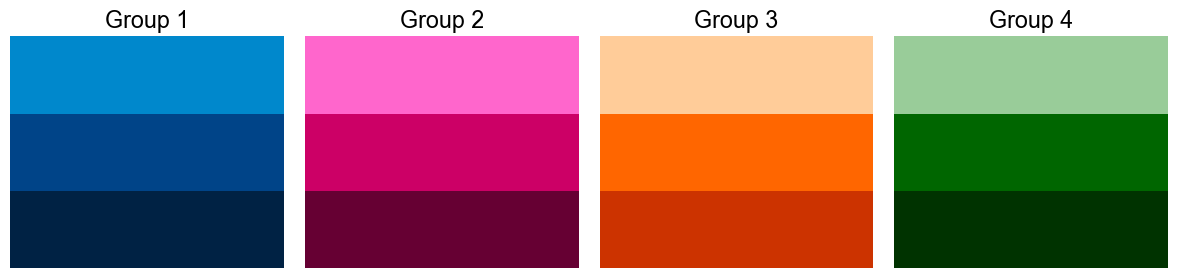

In [192]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

colors = {
    'Group 1': ['#002244', '#004488', '#0088CC'],  # Even Deeper Blues
    'Group 2': ['#660033', '#CC0066', '#FF66CC'],  # Even Deeper Purples to Light Pinks
    'Group 3': ['#CC3300', '#FF6600', '#FFCC99'],  # Even Deeper Oranges to Pale Oranges
    'Group 4': ['#003300', '#006600', '#99CC99']   # Even Deeper Greens
}

# Create figure
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# Plot each color group
for i, (group, shades) in enumerate(colors.items()):
    for j, color in enumerate(shades):
        rect = patches.Rectangle((0, j), 1, 1, facecolor=color)
        axs[i].add_patch(rect)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 3)
    axs[i].set_title(group)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [43]:
num_epochs = 400

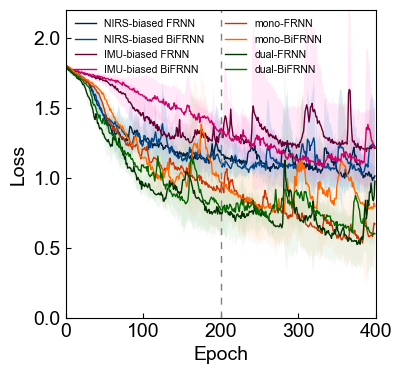

In [73]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_losses_rnn_nirs_biased_mean, linewidth=1, c=colors['Group 1'][0], label='NIRS-biased FRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_nirs_biased_mean - train_losses_rnn_nirs_biased_std,
                train_losses_rnn_nirs_biased_mean + train_losses_rnn_nirs_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_nirs_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='NIRS-biased BiFRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_nirs_biased_bi_mean - train_losses_rnn_nirs_biased_bi_std,
                train_losses_rnn_nirs_biased_bi_mean + train_losses_rnn_nirs_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')


ax.plot(train_losses_rnn_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='IMU-biased FRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_imu_biased_mean - train_losses_rnn_imu_biased_std,
                train_losses_rnn_imu_biased_mean + train_losses_rnn_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='IMU-biased BiFRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_imu_biased_bi_mean - train_losses_rnn_imu_biased_bi_std,
                train_losses_rnn_imu_biased_bi_mean + train_losses_rnn_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-FRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_mono_mean - train_losses_rnn_mono_std,
                train_losses_rnn_mono_mean + train_losses_rnn_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiFRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_mono_bi_mean - train_losses_rnn_mono_bi_std,
                train_losses_rnn_mono_bi_mean + train_losses_rnn_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-FRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_dual_mean - train_losses_rnn_dual_std,
                train_losses_rnn_dual_mean + train_losses_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_losses_rnn_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiFRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_dual_bi_mean - train_losses_rnn_dual_bi_std,
                train_losses_rnn_dual_bi_mean + train_losses_rnn_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',
          fontsize=7.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/loss_all_frnn.png', dpi=600, bbox_inches='tight')
plt.show()

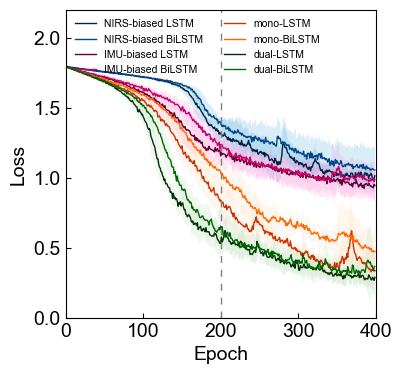

In [74]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

# Plot for LSTM pv_biased
ax.plot(train_losses_lstm_nirs_biased_mean, linewidth=1, c=colors['Group 1'][0], label='NIRS-biased LSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_nirs_biased_mean - train_losses_lstm_nirs_biased_std,
                train_losses_lstm_nirs_biased_mean + train_losses_lstm_nirs_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_losses_lstm_nirs_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='NIRS-biased BiLSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_nirs_biased_bi_mean - train_losses_lstm_nirs_biased_bi_std,
                train_losses_lstm_nirs_biased_bi_mean + train_losses_lstm_nirs_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

# Plot for LSTM imu_biased
ax.plot(train_losses_lstm_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='IMU-biased LSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_imu_biased_mean - train_losses_lstm_imu_biased_std,
                train_losses_lstm_imu_biased_mean + train_losses_lstm_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

# Plot for LSTM imu_biased_bi
ax.plot(train_losses_lstm_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='IMU-biased BiLSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_imu_biased_bi_mean - train_losses_lstm_imu_biased_bi_std,
                train_losses_lstm_imu_biased_bi_mean + train_losses_lstm_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

# Plot for LSTM mono
ax.plot(train_losses_lstm_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-LSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_mono_mean - train_losses_lstm_mono_std,
                train_losses_lstm_mono_mean + train_losses_lstm_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

# Plot for LSTM mono_bi
ax.plot(train_losses_lstm_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiLSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_mono_bi_mean - train_losses_lstm_mono_bi_std,
                train_losses_lstm_mono_bi_mean + train_losses_lstm_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

# Plot for LSTM dual
ax.plot(train_losses_lstm_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-LSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_dual_mean - train_losses_lstm_dual_std,
                train_losses_lstm_dual_mean + train_losses_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

# Plot for LSTM dual_bi
ax.plot(train_losses_lstm_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiLSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_dual_bi_mean - train_losses_lstm_dual_bi_std,
                train_losses_lstm_dual_bi_mean + train_losses_lstm_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',
          fontsize=7.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/loss_all_lstm.png', dpi=600, bbox_inches='tight')
plt.show()

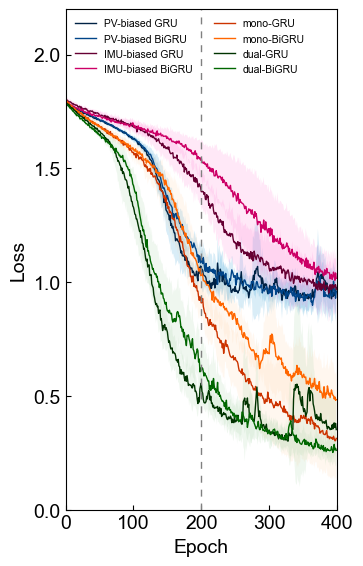

In [199]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

# Plot for GRU pv_biased
ax.plot(train_losses_gru_nirs_biased_mean, linewidth=1, c=colors['Group 1'][0], label='PV-biased GRU')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_nirs_biased_mean - train_losses_gru_nirs_biased_std,
                train_losses_gru_nirs_biased_mean + train_losses_gru_nirs_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

# Plot for GRU pv_biased_bi
ax.plot(train_losses_gru_nirs_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='PV-biased BiGRU')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_nirs_biased_bi_mean - train_losses_gru_nirs_biased_bi_std,
                train_losses_gru_nirs_biased_bi_mean + train_losses_gru_nirs_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

# Plot for GRU imu_biased
ax.plot(train_losses_gru_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='IMU-biased GRU')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_imu_biased_mean - train_losses_gru_imu_biased_std,
                train_losses_gru_imu_biased_mean + train_losses_gru_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

# Plot for GRU imu_biased_bi
ax.plot(train_losses_gru_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='IMU-biased BiGRU')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_imu_biased_bi_mean - train_losses_gru_imu_biased_bi_std,
                train_losses_gru_imu_biased_bi_mean + train_losses_gru_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

# Plot for GRU mono
ax.plot(train_losses_gru_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-GRU')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_mono_mean - train_losses_gru_mono_std,
                train_losses_gru_mono_mean + train_losses_gru_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

# Plot for GRU mono_bi
ax.plot(train_losses_gru_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiGRU')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_mono_bi_mean - train_losses_gru_mono_bi_std,
                train_losses_gru_mono_bi_mean + train_losses_gru_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

# Plot for GRU dual
ax.plot(train_losses_gru_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-GRU')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_dual_mean - train_losses_gru_dual_std,
                train_losses_gru_dual_mean + train_losses_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

# Plot for GRU dual_bi
ax.plot(train_losses_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiGRU')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_dual_bi_mean - train_losses_gru_dual_bi_std,
                train_losses_gru_dual_bi_mean + train_losses_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',
          fontsize=7.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/loss_all_gru_full.png', dpi=600, bbox_inches='tight')
plt.show()

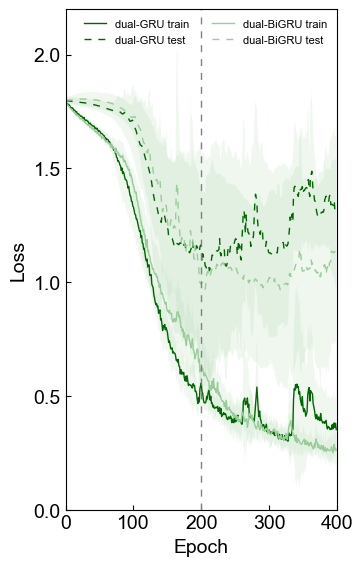

In [207]:
fig = plt.figure(figsize=[3.5, 6.5])
ax = fig.add_subplot()

ax.plot(train_losses_gru_dual_mean, linewidth=1, c=colors['Group 4'][1], label='dual-GRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_dual_mean - train_losses_gru_dual_std,
                train_losses_gru_dual_mean + train_losses_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_losses_gru_dual_mean, linewidth=1, c=colors['Group 4'][1], label='dual-GRU test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_losses_gru_dual_mean - test_losses_gru_dual_std,
                test_losses_gru_dual_mean + test_losses_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_losses_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][2], label='dual-BiGRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_dual_bi_mean - train_losses_gru_dual_bi_std,
                train_losses_gru_dual_bi_mean + train_losses_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_losses_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][2], label='dual-BiGRU test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_losses_gru_dual_bi_mean - test_losses_gru_dual_bi_std,
                test_losses_gru_dual_bi_mean + test_losses_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(loc='upper right',
          fontsize=8, frameon=False, ncols=2)

plt.show()

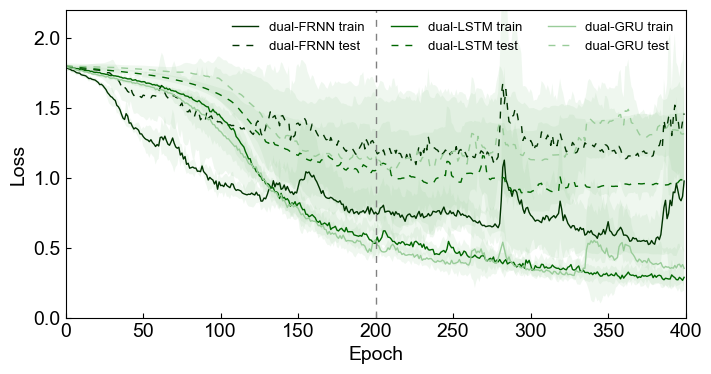

In [127]:
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot()

ax.plot(train_losses_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-FRNN train')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_rnn_dual_mean - train_losses_rnn_dual_std,
                train_losses_rnn_dual_mean + train_losses_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_losses_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-FRNN test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_losses_rnn_dual_mean - test_losses_rnn_dual_std,
                test_losses_rnn_dual_mean + test_losses_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_losses_lstm_dual_mean, linewidth=1, c=colors['Group 4'][1], label='dual-LSTM train')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_lstm_dual_mean - train_losses_lstm_dual_std,
                train_losses_lstm_dual_mean + train_losses_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_losses_lstm_dual_mean, linewidth=1, c=colors['Group 4'][1], label='dual-LSTM test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_losses_lstm_dual_mean - test_losses_lstm_dual_std,
                test_losses_lstm_dual_mean + test_losses_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_losses_gru_dual_mean, linewidth=1, c=colors['Group 4'][2], label='dual-GRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_gru_dual_mean - train_losses_gru_dual_std,
                train_losses_gru_dual_mean + train_losses_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_losses_gru_dual_mean, linewidth=1, c=colors['Group 4'][2], label='dual-GRU test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_losses_gru_dual_mean - test_losses_gru_dual_std,
                test_losses_gru_dual_mean + test_losses_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(loc='upper right',
          fontsize=9.5, frameon=False, ncols=3)

plt.savefig('../results/fig3/loss_all.png', dpi=600, bbox_inches='tight')
plt.show()

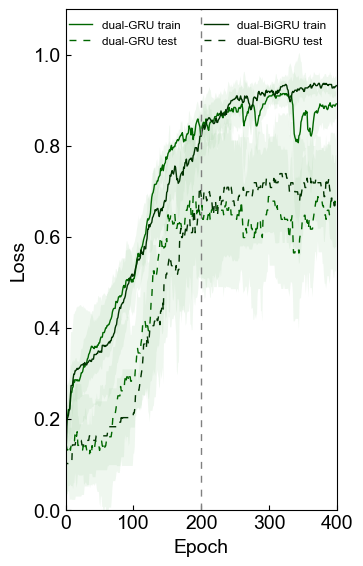

In [215]:
fig = plt.figure(figsize=[3.5, 6.5])

ax = fig.add_subplot()
ax.plot(train_accuracies_gru_dual_mean, linewidth=1, c=colors['Group 4'][1], label='dual-GRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_mean - train_accuracies_gru_dual_std,
                train_accuracies_gru_dual_mean + train_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_dual_mean, linewidth=1, c=colors['Group 4'][1], label='dual-GRU test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_dual_mean - test_accuracies_gru_dual_std,
                test_accuracies_gru_dual_mean + test_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][0], label='dual-BiGRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_bi_mean - train_accuracies_gru_dual_bi_std,
                train_accuracies_gru_dual_bi_mean + train_accuracies_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][0], label='dual-BiGRU test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_dual_bi_mean - test_accuracies_gru_dual_bi_std,
                test_accuracies_gru_dual_bi_mean + test_accuracies_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(loc='upper right',
          fontsize=8.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/accuracy_dual.png', dpi=600, bbox_inches='tight')
plt.show()

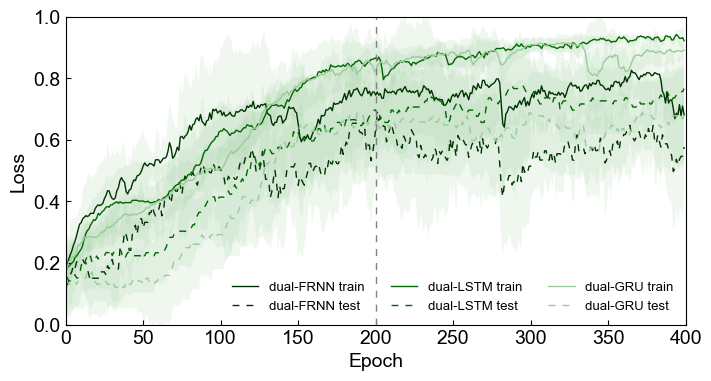

In [129]:
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-FRNN train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_mean - test_accuracies_rnn_dual_std,
                train_accuracies_rnn_dual_mean + test_accuracies_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-FRNN test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_rnn_dual_mean - test_accuracies_rnn_dual_std,
                test_accuracies_rnn_dual_mean + test_accuracies_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_dual_mean, linewidth=1, c=colors['Group 4'][1], label='dual-LSTM train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_mean - train_accuracies_lstm_dual_std,
                train_accuracies_lstm_dual_mean + train_accuracies_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_lstm_dual_mean, linewidth=1, c=colors['Group 4'][1], label='dual-LSTM test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_lstm_dual_mean - test_accuracies_lstm_dual_std,
                test_accuracies_lstm_dual_mean + test_accuracies_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_dual_mean, linewidth=1, c=colors['Group 4'][2], label='dual-GRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_mean - train_accuracies_gru_dual_std,
                train_accuracies_gru_dual_mean + train_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_dual_mean, linewidth=1, c=colors['Group 4'][2], label='dual-GRU test', ls=(0, (5, 5)))
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_dual_mean - test_accuracies_gru_dual_std,
                test_accuracies_gru_dual_mean + test_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 2.5,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.0)
# ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(loc='lower right',
          fontsize=9.5, frameon=False, ncols=3)

plt.savefig('../results/fig3/accuracy_all.png', dpi=600, bbox_inches='tight')
plt.show()

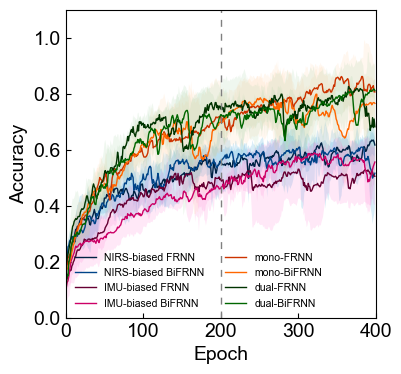

In [79]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

# Adding 'rnn' to variable names for accuracies plots
ax.plot(train_accuracies_rnn_nirs_biased_mean, linewidth=1, c=colors['Group 1'][0], label='NIRS-biased FRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_nirs_biased_mean - train_accuracies_rnn_nirs_biased_std,
                train_accuracies_rnn_nirs_biased_mean + train_accuracies_rnn_nirs_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_nirs_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='NIRS-biased BiFRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_nirs_biased_bi_mean - train_accuracies_rnn_nirs_biased_bi_std,
                train_accuracies_rnn_nirs_biased_bi_mean + train_accuracies_rnn_nirs_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='IMU-biased FRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_imu_biased_mean - train_accuracies_rnn_imu_biased_std,
                train_accuracies_rnn_imu_biased_mean + train_accuracies_rnn_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='IMU-biased BiFRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_imu_biased_bi_mean - train_accuracies_rnn_imu_biased_bi_std,
                train_accuracies_rnn_imu_biased_bi_mean + train_accuracies_rnn_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-FRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_mono_mean - train_accuracies_rnn_mono_std,
                train_accuracies_rnn_mono_mean + train_accuracies_rnn_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiFRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_mono_bi_mean - train_accuracies_rnn_mono_bi_std,
                train_accuracies_rnn_mono_bi_mean + train_accuracies_rnn_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-FRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_mean - train_accuracies_rnn_dual_std,
                train_accuracies_rnn_dual_mean + train_accuracies_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_rnn_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiFRNN')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_bi_mean - train_accuracies_rnn_dual_bi_std,
                train_accuracies_rnn_dual_bi_mean + train_accuracies_rnn_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 0), loc='lower left', fontsize=7.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/acc_all_frnn.png', dpi=600, bbox_inches='tight')

plt.show()

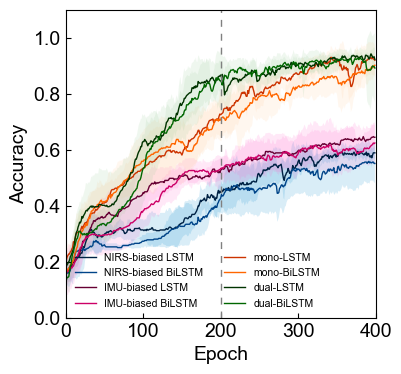

In [83]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

# Adding 'lstm' to variable names for accuracies plots
ax.plot(train_accuracies_lstm_nirs_biased_mean, linewidth=1, c=colors['Group 1'][0], label='NIRS-biased LSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_nirs_biased_mean - train_accuracies_lstm_nirs_biased_std,
                train_accuracies_lstm_nirs_biased_mean + train_accuracies_lstm_nirs_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_nirs_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='NIRS-biased BiLSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_nirs_biased_bi_mean - train_accuracies_lstm_nirs_biased_bi_std,
                train_accuracies_lstm_nirs_biased_bi_mean + train_accuracies_lstm_nirs_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='IMU-biased LSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_imu_biased_mean - train_accuracies_lstm_imu_biased_std,
                train_accuracies_lstm_imu_biased_mean + train_accuracies_lstm_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='IMU-biased BiLSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_imu_biased_bi_mean - train_accuracies_lstm_imu_biased_bi_std,
                train_accuracies_lstm_imu_biased_bi_mean + train_accuracies_lstm_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-LSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_mono_mean - train_accuracies_lstm_mono_std,
                train_accuracies_lstm_mono_mean + train_accuracies_lstm_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiLSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_mono_bi_mean - train_accuracies_lstm_mono_bi_std,
                train_accuracies_lstm_mono_bi_mean + train_accuracies_lstm_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-LSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_mean - train_accuracies_lstm_dual_std,
                train_accuracies_lstm_dual_mean + train_accuracies_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_lstm_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiLSTM')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_bi_mean - train_accuracies_lstm_dual_bi_std,
                train_accuracies_lstm_dual_bi_mean + train_accuracies_lstm_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 0), loc='lower left', fontsize=7.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/acc_all_lstm.png', dpi=600, bbox_inches='tight')
plt.show()

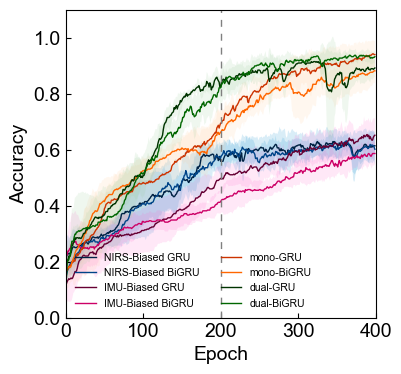

In [82]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

# Adding 'gru' to variable names for accuracies plots
ax.plot(train_accuracies_gru_nirs_biased_mean, linewidth=1, c=colors['Group 1'][0], label='NIRS-Biased GRU')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_nirs_biased_mean - train_accuracies_gru_nirs_biased_std,
                train_accuracies_gru_nirs_biased_mean + train_accuracies_gru_nirs_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_nirs_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='NIRS-Biased BiGRU')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_nirs_biased_bi_mean - train_accuracies_gru_nirs_biased_bi_std,
                train_accuracies_gru_nirs_biased_bi_mean + train_accuracies_gru_nirs_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='IMU-Biased GRU')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_imu_biased_mean - train_accuracies_gru_imu_biased_std,
                train_accuracies_gru_imu_biased_mean + train_accuracies_gru_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='IMU-Biased BiGRU')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_imu_biased_bi_mean - train_accuracies_gru_imu_biased_bi_std,
                train_accuracies_gru_imu_biased_bi_mean + train_accuracies_gru_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-GRU')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_mono_mean - train_accuracies_gru_mono_std,
                train_accuracies_gru_mono_mean + train_accuracies_gru_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiGRU')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_mono_bi_mean - train_accuracies_gru_mono_bi_std,
                train_accuracies_gru_mono_bi_mean + train_accuracies_gru_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-GRU')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_mean - train_accuracies_gru_dual_std,
                train_accuracies_gru_dual_mean + train_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiGRU')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_bi_mean - train_accuracies_gru_dual_bi_std,
                train_accuracies_gru_dual_bi_mean + train_accuracies_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 0), loc='lower left', fontsize=7.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/acc_all_gru.png', dpi=600, bbox_inches='tight')

plt.show()

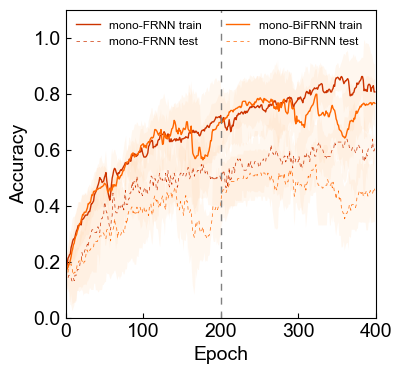

In [96]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_rnn_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-FRNN train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_mono_mean - train_accuracies_rnn_mono_std,
                train_accuracies_rnn_mono_mean + train_accuracies_rnn_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_rnn_mono_mean, linewidth=0.5, c=colors['Group 3'][0], ls=(0, (5, 5)), label='mono-FRNN test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_rnn_mono_mean - test_accuracies_rnn_mono_std,
                test_accuracies_rnn_mono_mean + test_accuracies_rnn_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_rnn_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiFRNN train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_mono_bi_mean - train_accuracies_rnn_mono_bi_std,
                train_accuracies_rnn_mono_bi_mean + train_accuracies_rnn_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_rnn_mono_bi_mean, linewidth=0.5, c=colors['Group 3'][1], ls=(0, (5, 5)), label='mono-BiFRNN test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_rnn_mono_bi_mean - test_accuracies_rnn_mono_bi_std,
                test_accuracies_rnn_mono_bi_mean + test_accuracies_rnn_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=8.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/train_vs_test_mono_frnn.png', dpi=600, bbox_inches='tight')

plt.show()

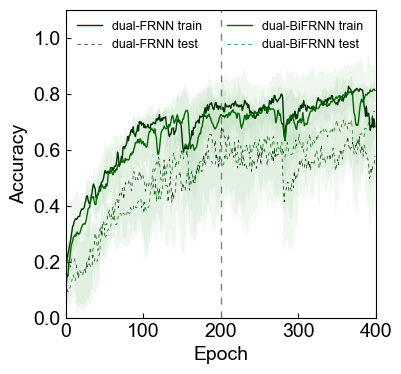

In [93]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_rnn_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-FRNN train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_mean - train_accuracies_rnn_dual_std,
                train_accuracies_rnn_dual_mean + train_accuracies_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_rnn_dual_mean, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='dual-FRNN test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_rnn_dual_mean - test_accuracies_rnn_dual_std,
                test_accuracies_rnn_dual_mean + test_accuracies_rnn_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_rnn_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiFRNN train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_rnn_dual_bi_mean - train_accuracies_rnn_dual_bi_std,
                train_accuracies_rnn_dual_bi_mean + train_accuracies_rnn_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_rnn_dual_bi_mean, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='dual-BiFRNN test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_rnn_dual_bi_mean - test_accuracies_rnn_dual_bi_std,
                test_accuracies_rnn_dual_bi_mean + test_accuracies_rnn_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.savefig('../results/fig3/train_vs_test_frnn.png', dpi=600, bbox_inches='tight')

plt.show()

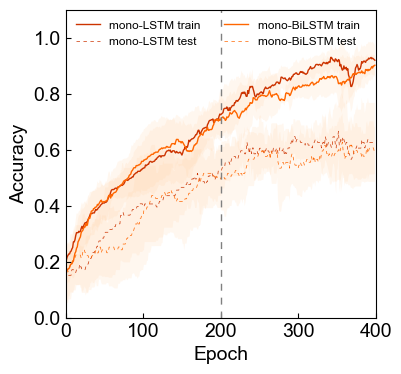

In [97]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_lstm_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-LSTM train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_mono_mean - train_accuracies_lstm_mono_std,
                train_accuracies_lstm_mono_mean + train_accuracies_lstm_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_lstm_mono_mean, linewidth=0.5, c=colors['Group 3'][0], ls=(0, (5, 5)), label='mono-LSTM test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_lstm_mono_mean - test_accuracies_lstm_mono_std,
                test_accuracies_lstm_mono_mean + test_accuracies_lstm_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_lstm_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiLSTM train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_mono_bi_mean - train_accuracies_lstm_mono_bi_std,
                train_accuracies_lstm_mono_bi_mean + train_accuracies_lstm_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_lstm_mono_bi_mean, linewidth=0.5, c=colors['Group 3'][1], ls=(0, (5, 5)), label='mono-BiLSTM test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_lstm_mono_bi_mean - test_accuracies_lstm_mono_bi_std,
                test_accuracies_lstm_mono_bi_mean + test_accuracies_lstm_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=8.5, frameon=False, ncols=2)

plt.savefig('../results/fig3/train_vs_test_mono_lstm.png', dpi=600, bbox_inches='tight')

plt.show()

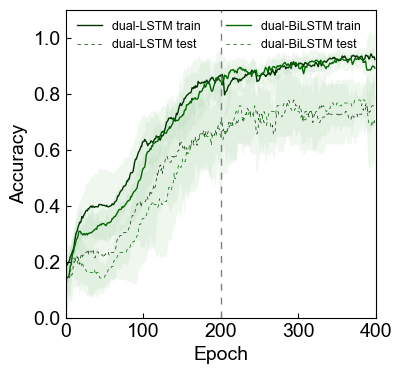

In [89]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_lstm_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-LSTM train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_mean - train_accuracies_lstm_dual_std,
                train_accuracies_lstm_dual_mean + train_accuracies_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_lstm_dual_mean, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='dual-LSTM test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_lstm_dual_mean - test_accuracies_lstm_dual_std,
                test_accuracies_lstm_dual_mean + test_accuracies_lstm_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_lstm_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiLSTM train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_lstm_dual_bi_mean - train_accuracies_lstm_dual_bi_std,
                train_accuracies_lstm_dual_bi_mean + train_accuracies_lstm_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_lstm_dual_bi_mean, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='dual-BiLSTM test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_lstm_dual_bi_mean - test_accuracies_lstm_dual_bi_std,
                test_accuracies_lstm_dual_bi_mean + test_accuracies_lstm_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.savefig('../results/fig3/train_vs_test_lstm.png', dpi=600, bbox_inches='tight')

plt.show()

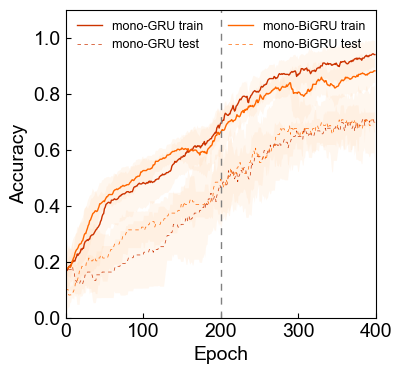

In [98]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_gru_mono_mean, linewidth=1, c=colors['Group 3'][0], label='mono-GRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_mono_mean - train_accuracies_gru_mono_std,
                train_accuracies_gru_mono_mean + train_accuracies_gru_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_mono_mean, linewidth=0.5, c=colors['Group 3'][0], ls=(0, (5, 5)), label='mono-GRU test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_mono_mean - test_accuracies_gru_mono_std,
                test_accuracies_gru_mono_mean + test_accuracies_gru_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_gru_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='mono-BiGRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_mono_bi_mean - train_accuracies_gru_mono_bi_std,
                train_accuracies_gru_mono_bi_mean + train_accuracies_gru_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_mono_bi_mean, linewidth=0.5, c=colors['Group 3'][1], ls=(0, (5, 5)), label='mono-BiGRU test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_mono_bi_mean - test_accuracies_gru_mono_bi_std,
                test_accuracies_gru_mono_bi_mean + test_accuracies_gru_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.savefig('../results/fig3/train_vs_test_mono_gru.png', dpi=600, bbox_inches='tight')

plt.show()


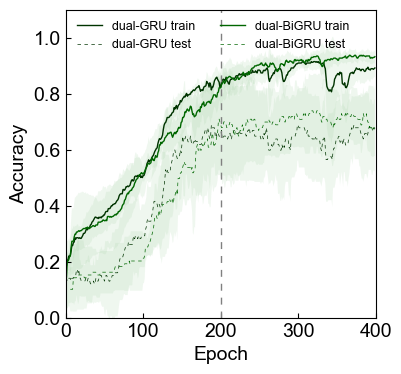

In [ ]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_gru_dual_mean, linewidth=1, c=colors['Group 4'][0], label='dual-GRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_mean - train_accuracies_gru_dual_std,
                train_accuracies_gru_dual_mean + train_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_dual_mean, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='dual-GRU test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_dual_mean - test_accuracies_gru_dual_std,
                test_accuracies_gru_dual_mean + test_accuracies_gru_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_gru_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='dual-BiGRU train')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_gru_dual_bi_mean - train_accuracies_gru_dual_bi_std,
                train_accuracies_gru_dual_bi_mean + train_accuracies_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_gru_dual_bi_mean, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='dual-BiGRU test')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_gru_dual_bi_mean - test_accuracies_gru_dual_bi_std,
                test_accuracies_gru_dual_bi_mean + test_accuracies_gru_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.savefig('../results/fig3/train_vs_test_gru.png', dpi=600, bbox_inches='tight')

plt.show()


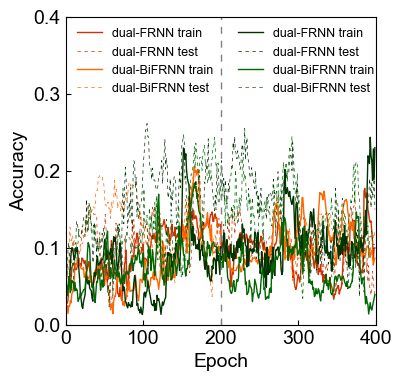

In [104]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_rnn_mono_std, linewidth=1, c=colors['Group 3'][0], label='dual-FRNN train')
ax.plot(test_accuracies_rnn_mono_std, linewidth=0.5, c=colors['Group 3'][0], ls=(0, (5, 5)), label='dual-FRNN test')
ax.plot(train_accuracies_rnn_mono_bi_std, linewidth=1, c=colors['Group 3'][1], label='dual-BiFRNN train')
ax.plot(test_accuracies_rnn_mono_bi_std, linewidth=0.5, c=colors['Group 3'][1], ls=(0, (5, 5)), label='dual-BiFRNN test')
ax.plot(train_accuracies_rnn_dual_std, linewidth=1, c=colors['Group 4'][0], label='dual-FRNN train')
ax.plot(test_accuracies_rnn_dual_std, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='dual-FRNN test')
ax.plot(train_accuracies_rnn_dual_bi_std, linewidth=1, c=colors['Group 4'][1], label='dual-BiFRNN train')
ax.plot(test_accuracies_rnn_dual_bi_std, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='dual-BiFRNN test')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 0.4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.savefig('../results/fig3/std_frnn.png', dpi=600, bbox_inches='tight')

plt.show()


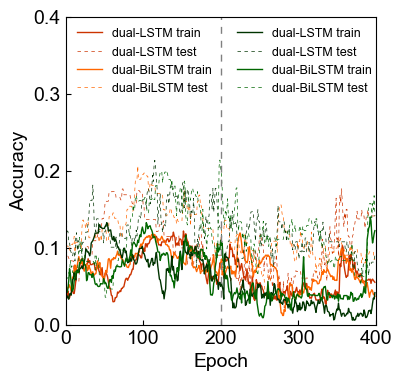

In [105]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_lstm_mono_std, linewidth=1, c=colors['Group 3'][0], label='dual-LSTM train')
ax.plot(test_accuracies_lstm_mono_std, linewidth=0.5, c=colors['Group 3'][0], ls=(0, (5, 5)), label='dual-LSTM test')
ax.plot(train_accuracies_lstm_mono_bi_std, linewidth=1, c=colors['Group 3'][1], label='dual-BiLSTM train')
ax.plot(test_accuracies_lstm_mono_bi_std, linewidth=0.5, c=colors['Group 3'][1], ls=(0, (5, 5)), label='dual-BiLSTM test')
ax.plot(train_accuracies_lstm_dual_std, linewidth=1, c=colors['Group 4'][0], label='dual-LSTM train')
ax.plot(test_accuracies_lstm_dual_std, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='dual-LSTM test')
ax.plot(train_accuracies_lstm_dual_bi_std, linewidth=1, c=colors['Group 4'][1], label='dual-BiLSTM train')
ax.plot(test_accuracies_lstm_dual_bi_std, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='dual-BiLSTM test')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 0.4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.savefig('../results/fig3/std_lstm.png', dpi=600, bbox_inches='tight')

plt.show()


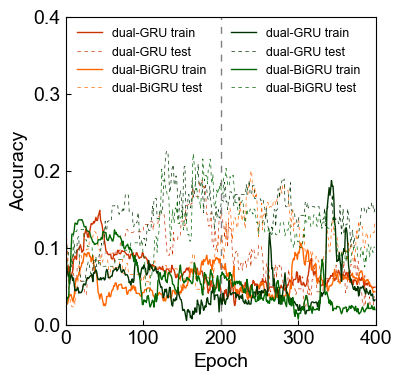

In [106]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot()

ax.plot(train_accuracies_gru_mono_std, linewidth=1, c=colors['Group 3'][0], label='dual-GRU train')
ax.plot(test_accuracies_gru_mono_std, linewidth=0.5, c=colors['Group 3'][0], ls=(0, (5, 5)), label='dual-GRU test')
ax.plot(train_accuracies_gru_mono_bi_std, linewidth=1, c=colors['Group 3'][1], label='dual-BiGRU train')
ax.plot(test_accuracies_gru_mono_bi_std, linewidth=0.5, c=colors['Group 3'][1], ls=(0, (5, 5)), label='dual-BiGRU test')
ax.plot(train_accuracies_gru_dual_std, linewidth=1, c=colors['Group 4'][0], label='dual-GRU train')
ax.plot(test_accuracies_gru_dual_std, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='dual-GRU test')
ax.plot(train_accuracies_gru_dual_bi_std, linewidth=1, c=colors['Group 4'][1], label='dual-BiGRU train')
ax.plot(test_accuracies_gru_dual_bi_std, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='dual-BiGRU test')

ax.vlines(200, 0, 1.1, linewidth=1, linestyles=(0, (5, 5)), colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 0.4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=9, frameon=False, ncols=2)

plt.savefig('../results/fig3/std_gru.png', dpi=600, bbox_inches='tight')

plt.show()


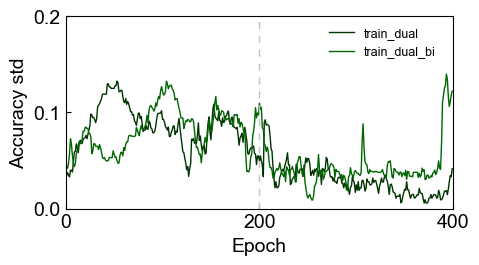

In [194]:
fig = plt.figure(figsize=[5, 2.5])
ax = fig.add_subplot()

ax.plot(train_accuracies_lstm_dual_std, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.plot(train_accuracies_lstm_dual_bi_std, linewidth=1, c=colors['Group 4'][1], label='train_dual_bi')

ax.vlines(200, 0, 2,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='silver')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 0.2)
ax.set_xticks([0, 200, 400])
ax.set_yticks(np.linspace(0, 0.2, 3))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy std')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0.65, 1), loc='upper left',
          fontsize=9, frameon=False, ncols=1)

# plt.savefig('../results/fig3/accuracy_dual_std_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

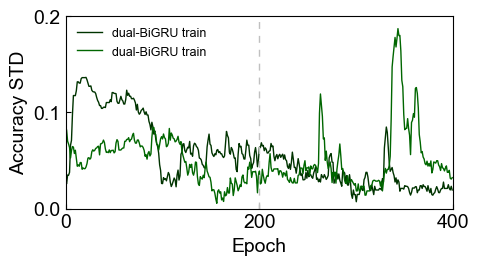

In [197]:
fig = plt.figure(figsize=[5, 2.5])
ax = fig.add_subplot()

ax.plot(train_accuracies_gru_dual_bi_std, linewidth=1, c=colors['Group 4'][0], label='dual-BiGRU train')
ax.plot(train_accuracies_gru_dual_std, linewidth=1, c=colors['Group 4'][1], label='dual-BiGRU train')

ax.vlines(200, 0, 2,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='silver')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 0.2)
ax.set_xticks([0, 200, 400])
ax.set_yticks(np.linspace(0, 0.2, 3))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy STD')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',
          fontsize=9, frameon=False, ncols=1)

plt.savefig('../results/fig3/accuracy_dual_std_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

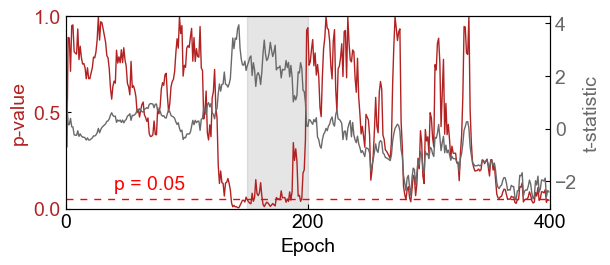

In [190]:
from scipy import stats

t_stat_train = []
p_val_train = []
t_stat_test = []
p_val_test = []

for idx in range(num_epochs):
    t, p = stats.ttest_ind(train_accuracies_gru_dual[:, idx], train_accuracies_gru_dual_bi[:, idx])
    t_stat_train.append(t)
    p_val_train.append(p)

    t, p = stats.ttest_ind(test_accuracies_gru_dual[:, idx], test_accuracies_gru_dual_bi[:, idx])
    t_stat_test.append(t)
    p_val_test.append(p)

fig, ax1 = plt.subplots(figsize=(6.25, 2.5))

# ax1.vlines(200, 0, 1,
#           linewidth=1,
#           linestyles=(0, (5, 5)),
#           colors='silver')
ax1.axvspan(150, 200, alpha=0.2, color='gray')

ax1.hlines(0.05, 0, num_epochs,
           linewidth=1,
           linestyles=(0, (5, 5)),
           colors='r')
ax1.text(40, 0.08, 'p = 0.05',
         ha='left', va='bottom',
         c='r')

ax1.set_xlim(0, num_epochs)
ax1.set_ylim(0, 1)
ax1.set_xticks([0, 200, 400])
ax1.set_yticks(np.linspace(0, 1, 3))
ax1.plot(p_val_train, lw=1, color='firebrick')
# ax1.plot(p_val_test, lw=0.5, ls=(0, (10, 10)), color='firebrick')
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', direction='in', labelcolor='firebrick')
ax1.set_ylabel('p-value', color='firebrick')

ax2 = ax1.twinx()
ax2.plot(t_stat_train, lw=1, color='dimgray')
# ax2.plot(t_stat_test, lw=0.5, ls=(0, (10, 10)), color='dimgray')
ax2.tick_params(axis='both', direction='in', labelcolor='dimgray')
ax2.set_ylabel('t-statistic', color='dimgray')

ax1.set_xlabel('Epoch')

# plt.savefig('../results/fig3/accuracy_dual_ttest.png', dpi=600, bbox_inches='tight')
plt.show()

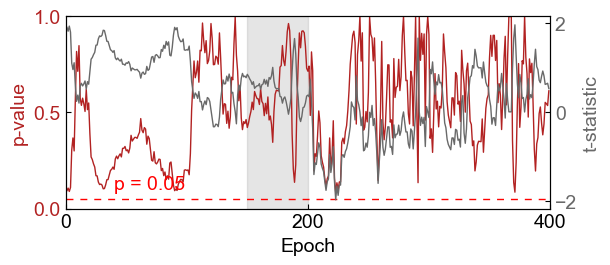

In [131]:
from scipy import stats

t_stat_train = []
p_val_train = []
t_stat_test = []
p_val_test = []

for idx in range(num_epochs):
    t, p = stats.ttest_ind(train_accuracies_lstm_dual[:, idx], train_accuracies_lstm_dual_bi[:, idx])
    t_stat_train.append(t)
    p_val_train.append(p)

    t, p = stats.ttest_ind(test_accuracies_lstm_dual[:, idx], test_accuracies_lstm_dual_bi[:, idx])
    t_stat_test.append(t)
    p_val_test.append(p)

fig, ax1 = plt.subplots(figsize=(6.25, 2.5))

# ax1.vlines(200, 0, 1,
#           linewidth=1,
#           linestyles=(0, (5, 5)),
#           colors='silver')
ax1.axvspan(150, 200, alpha=0.2, color='gray')

ax1.hlines(0.05, 0, num_epochs,
           linewidth=1,
           linestyles=(0, (5, 5)),
           colors='r')
ax1.text(40, 0.08, 'p = 0.05',
         ha='left', va='bottom',
         c='r')

ax1.set_xlim(0, num_epochs)
ax1.set_ylim(0, 1)
ax1.set_xticks([0, 200, 400])
ax1.set_yticks(np.linspace(0, 1, 3))
ax1.plot(p_val_train, lw=1, color='firebrick')
# ax1.plot(p_val_test, lw=0.5, ls=(0, (10, 10)), color='firebrick')
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', direction='in', labelcolor='firebrick')
ax1.set_ylabel('p-value', color='firebrick')

ax2 = ax1.twinx()
ax2.plot(t_stat_train, lw=1, color='dimgray')
# ax2.plot(t_stat_test, lw=0.5, ls=(0, (10, 10)), color='dimgray')
ax2.tick_params(axis='both', direction='in', labelcolor='dimgray')
ax2.set_ylabel('t-statistic', color='dimgray')

ax1.set_xlabel('Epoch')

# plt.savefig('../results/fig3/accuracy_dual_ttest.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
model_lstm_dual.eval()

incorrect_train_samples = []
incorrect_test_samples = []

with torch.no_grad():
    for photovoltage_data, euler_angle_data, labels in train_loader_dual:
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_lstm_dual(photovoltage_data, euler_angle_data)
        _, predicted = torch.max(outputs.data, 1)

        mismatches = predicted != labels.squeeze()
        if mismatches.any():
            incorrect_predictions = (photovoltage_data[mismatches],
                                     euler_angle_data[mismatches],
                                     labels[mismatches],
                                     predicted[mismatches])
            incorrect_train_samples.extend(zip(*incorrect_predictions))

with torch.no_grad():
    for photovoltage_data, euler_angle_data, labels in test_loader_dual:
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)
        # Forward pass
        outputs = model_lstm_dual(photovoltage_data, euler_angle_data)
        _, predicted = torch.max(outputs.data, 1)

        mismatches = predicted != labels.squeeze()
        if mismatches.any():
            incorrect_predictions = (photovoltage_data[mismatches],
                                     euler_angle_data[mismatches],
                                     labels[mismatches],
                                     predicted[mismatches])
            incorrect_test_samples.extend(zip(*incorrect_predictions))

incorrect_train_samples = incorrect_train_samples[:5]
incorrect_test_samples = incorrect_test_samples[:5]

In [ ]:
def plot_incorrect_samples(samples, title):
    if device != 'cpu':
        samples_cpu = []
        for sample in samples:
            samples_cpu.append([feature.to('cpu') for feature in sample])
        samples = samples_cpu
        
    plt.figure(figsize=(15, 15))
    for i, (photovoltage, euler_angle, true_label, pred_label) in enumerate(samples):
        # Creating a subplot for each sample
        plt.subplot(len(samples), 2, 2*i + 1)  # Photovoltage plot
        plt.plot(photovoltage.numpy())  # Assuming photovoltage is a waveform
        plt.title(f'Sample {i}: True Label = {Label(true_label.item()).name}, Predicted = {Label(pred_label.item()).name}')
        plt.ylabel('Photovoltage')

        plt.subplot(len(samples), 2, 2*i + 2)  # Euler angle plot
        plt.plot(euler_angle.numpy())  # Assuming euler_angle is a waveform
        plt.ylabel('Euler Angles')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_incorrect_samples(incorrect_train_samples, "Incorrect Training Samples")

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_predictions_and_labels(model, loader):
    all_predictions = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for samples, labels in loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = model(samples)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

def get_predictions_and_labels_dual(model, loader):
    all_predictions = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for pvs, imus, labels in loader:
            pvs = pvs.to(device)
            imus = imus.to(device)
            labels = labels.to(device)
            outputs = model(pvs, imus)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

In [216]:
old2new_mapping = {0: 0, 1: 2, 2: 4, 3: 5, 4: 1, 5: 3}

Confusion matrix --- **ALL**

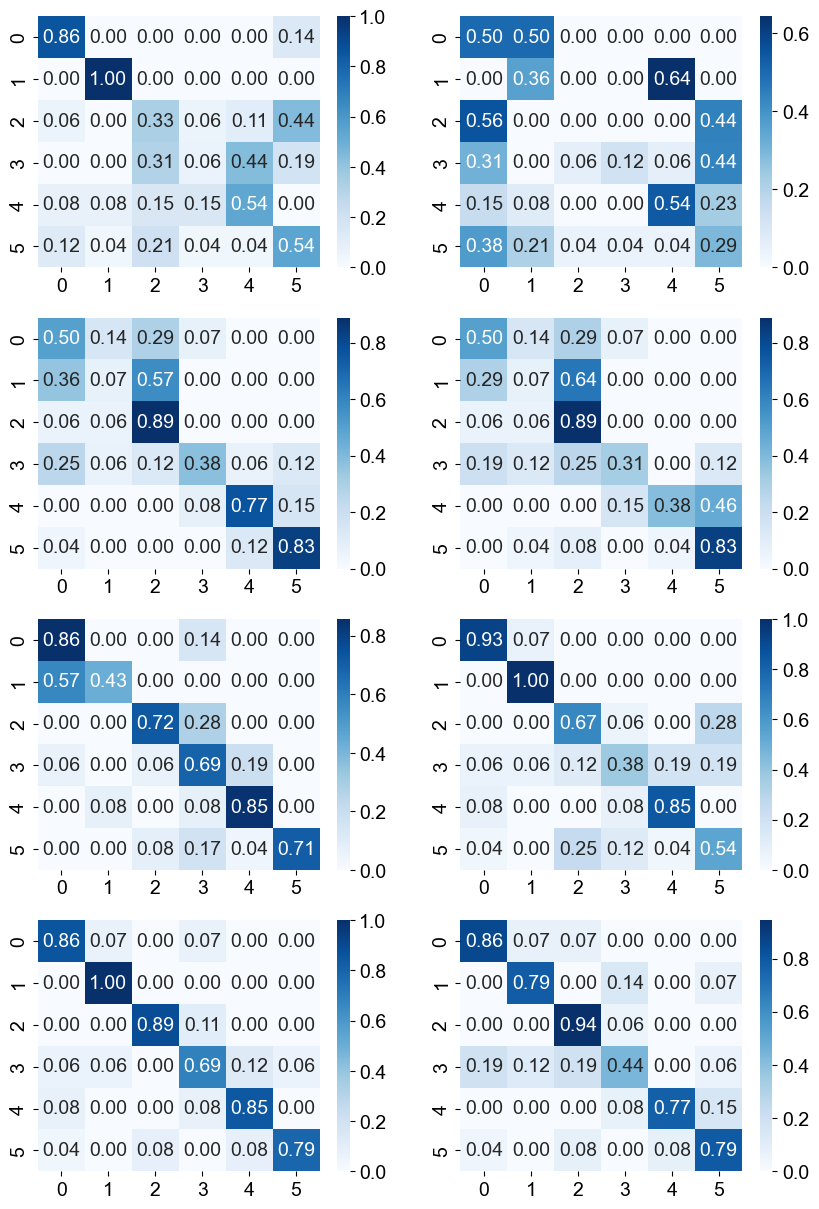

In [228]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(nirs_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(nirs_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(imu_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(imu_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(mono_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(mono_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(dual_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_rnn_dual, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(dual_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_rnn_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_rnn_all.png', dpi=600, bbox_inches='tight')

plt.show()

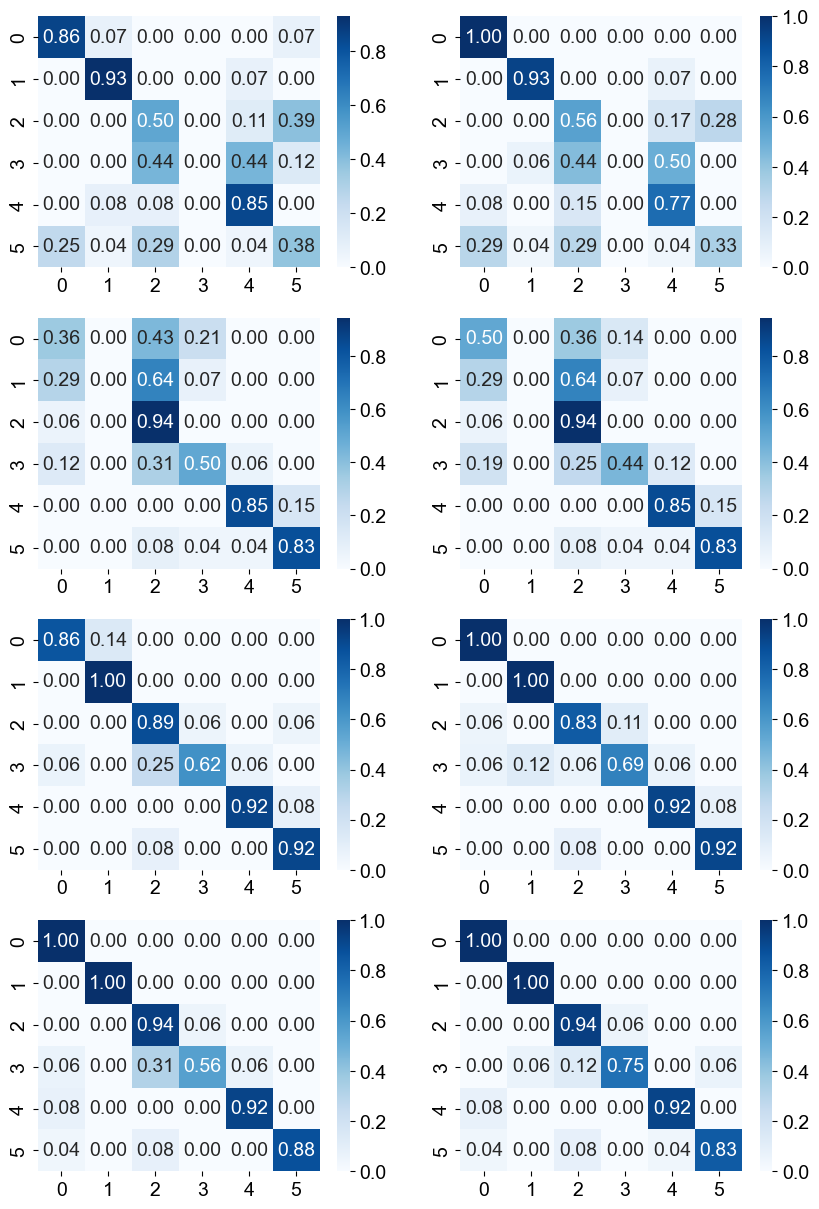

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(nirs_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(nirs_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(imu_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(imu_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(mono_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(mono_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(dual_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_lstm_dual, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(dual_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_lstm_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_lstm_all.png', dpi=600, bbox_inches='tight')

plt.show()

c:\Users\y1hli\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\rnn.py:998: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


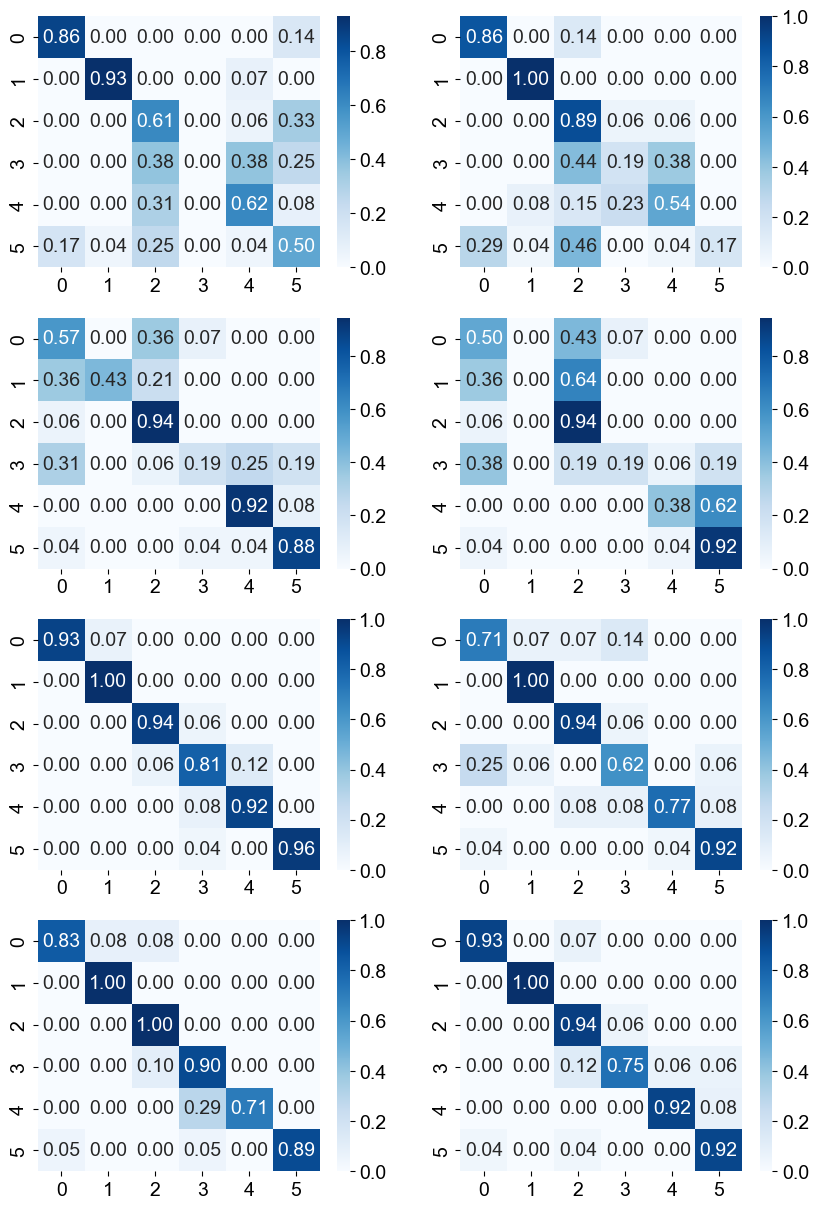

In [239]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(nirs_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(nirs_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(imu_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(imu_biased_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(mono_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(mono_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual (best model)
loader = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(best_model, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(dual_ds, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_gru_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_gru_all.png', dpi=600, bbox_inches='tight')

plt.show()

Confusion matrix --- **TRAIN**

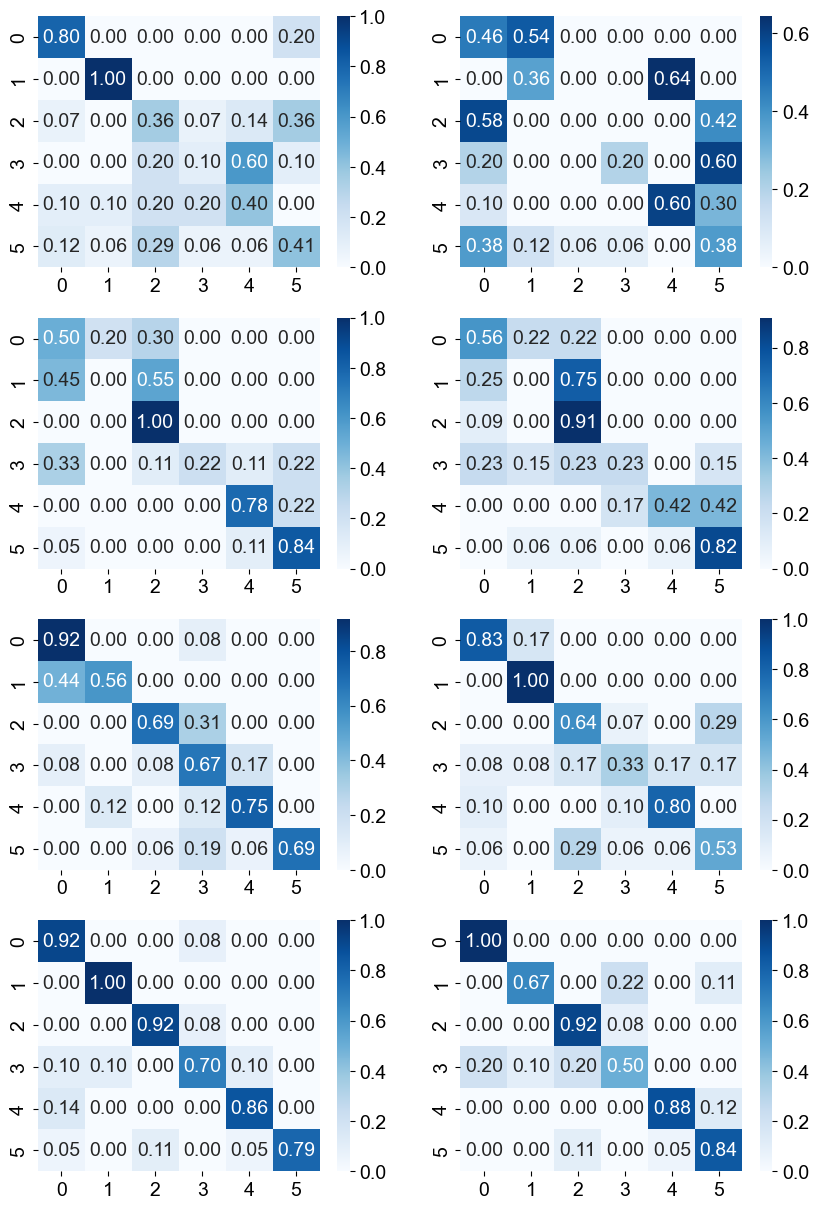

In [241]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(train_dataset_nirs_biased, batch_size=batch_size, shuffle=True)
predictions, labels = get_predictions_and_labels(model_rnn_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(train_dataset_nirs_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(train_dataset_imu_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(train_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(train_dataset_mono, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(train_dataset_mono_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_rnn_dual, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(train_dataset_dual_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_rnn_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_rnn_train.png', dpi=600, bbox_inches='tight')

plt.show()


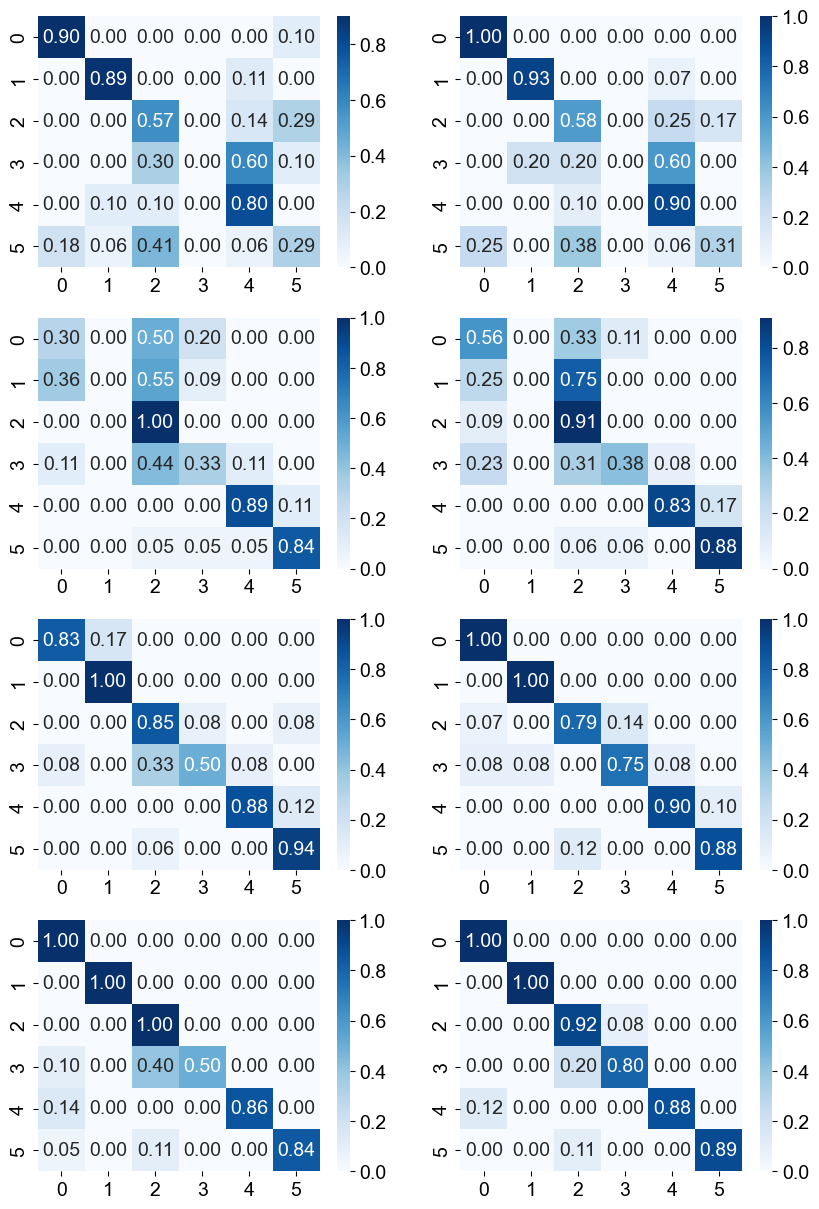

In [225]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(train_dataset_nirs_biased, batch_size=batch_size, shuffle=True)
predictions, labels = get_predictions_and_labels(model_lstm_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(train_dataset_nirs_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(train_dataset_imu_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(train_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(train_dataset_mono, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(train_dataset_mono_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_lstm_dual, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(train_dataset_dual_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_lstm_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_lstm_train.png', dpi=600, bbox_inches='tight')

plt.show()

c:\Users\y1hli\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\rnn.py:998: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


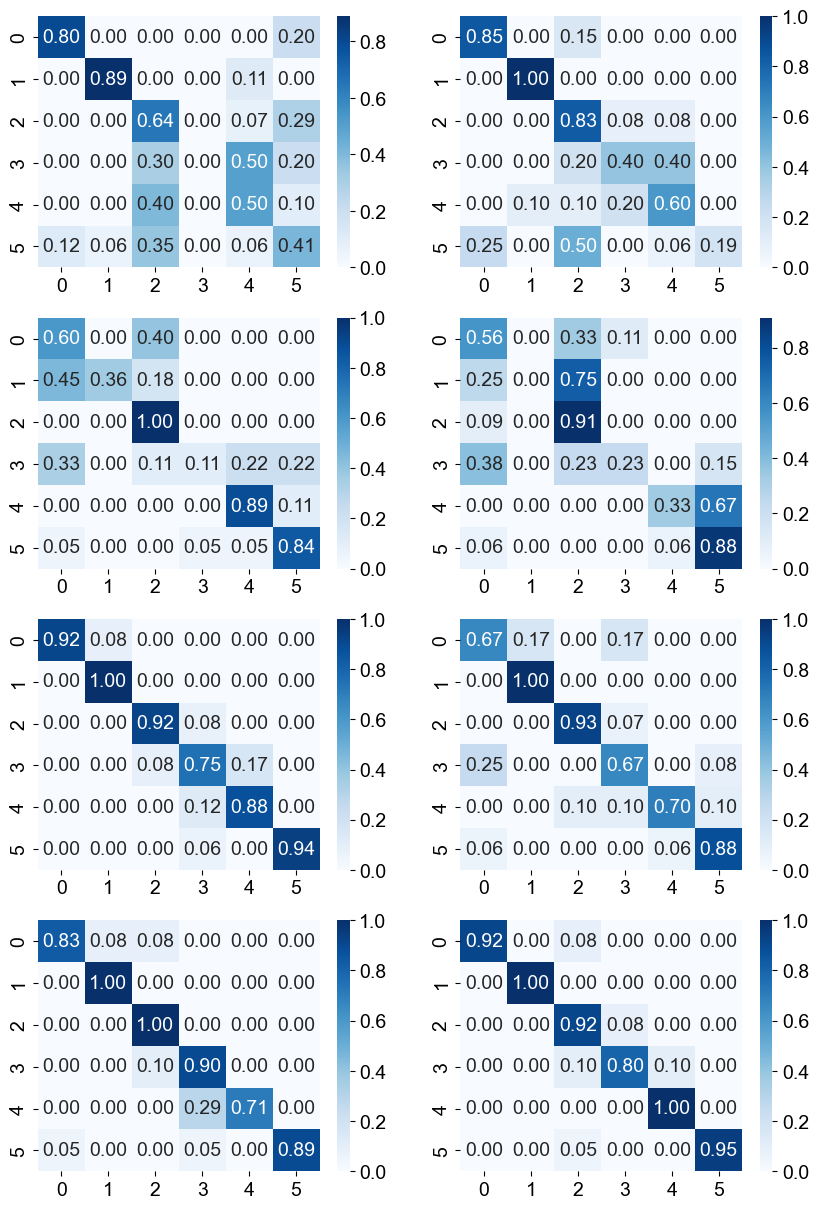

In [245]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(train_dataset_nirs_biased, batch_size=batch_size, shuffle=True)
predictions, labels = get_predictions_and_labels(model_gru_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(train_dataset_nirs_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(train_dataset_imu_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(train_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(train_dataset_mono, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(train_dataset_mono_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(best_model, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(train_dataset_dual_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_gru_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_gru_train.png', dpi=600, bbox_inches='tight')

plt.show()


Confusion matrix --- **TEST**

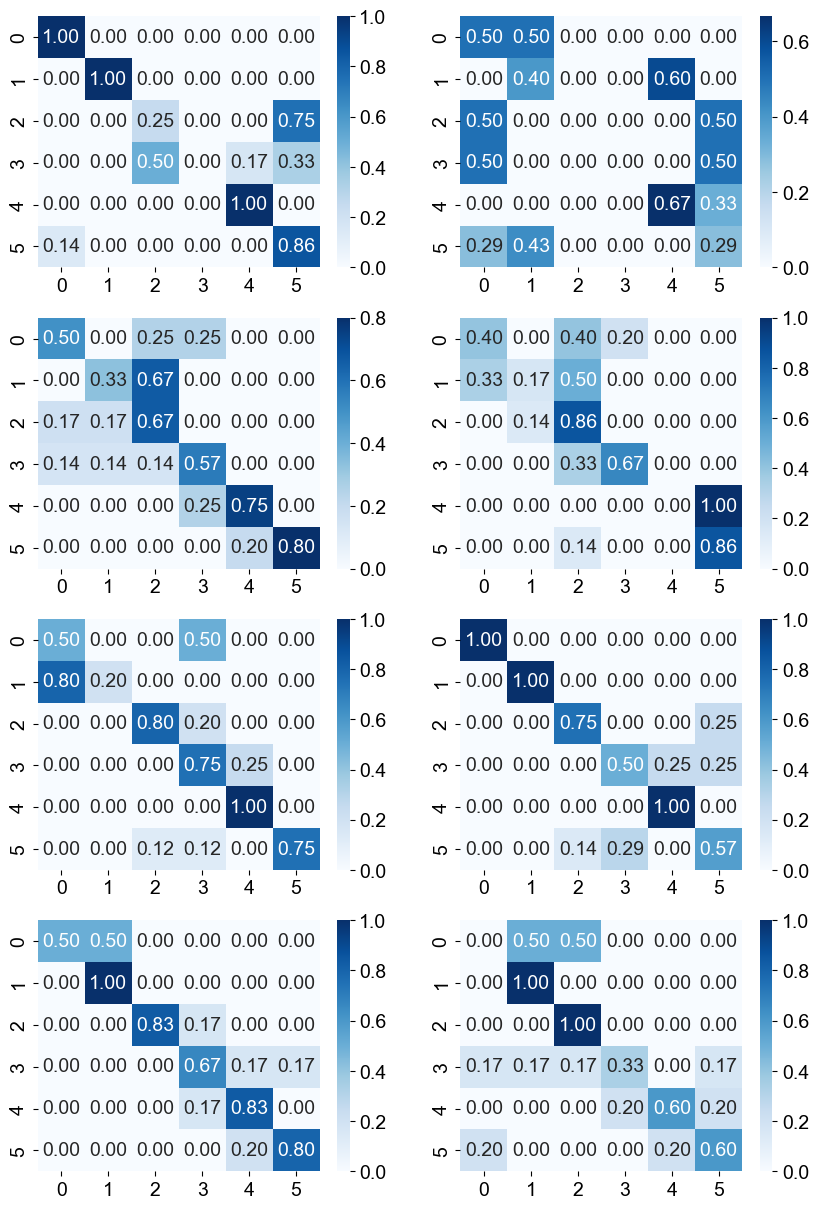

In [255]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(test_dataset_nirs_biased, batch_size=batch_size, shuffle=True)
predictions, labels = get_predictions_and_labels(model_rnn_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(test_dataset_nirs_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(test_dataset_imu_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(test_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(test_dataset_mono, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(test_dataset_mono_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_rnn_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_rnn_dual, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(test_dataset_dual_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_rnn_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_rnn_test.png', dpi=600, bbox_inches='tight')

plt.show()


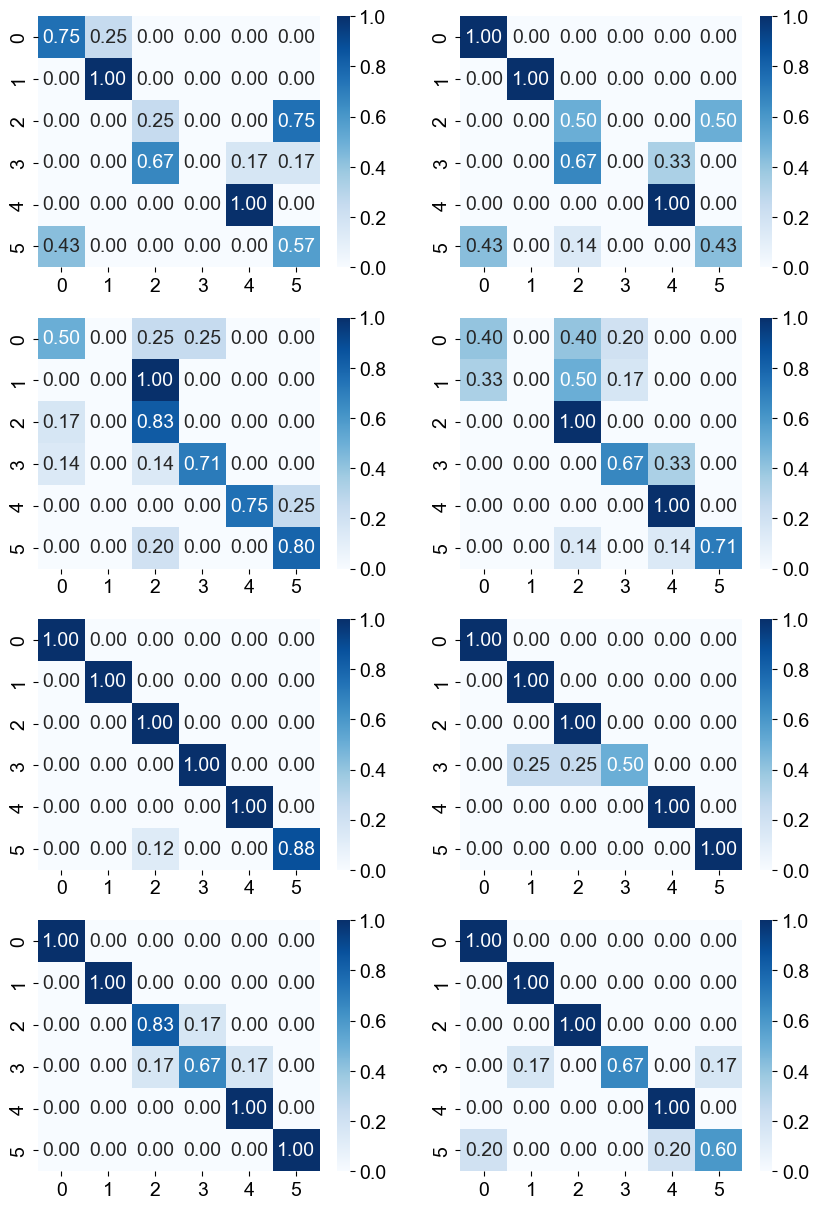

In [226]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(test_dataset_nirs_biased, batch_size=batch_size, shuffle=True)
predictions, labels = get_predictions_and_labels(model_lstm_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(test_dataset_nirs_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(test_dataset_imu_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(test_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(test_dataset_mono, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(test_dataset_mono_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_lstm_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_lstm_dual, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(test_dataset_dual_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_lstm_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_lstm_test.png', dpi=600, bbox_inches='tight')

plt.show()

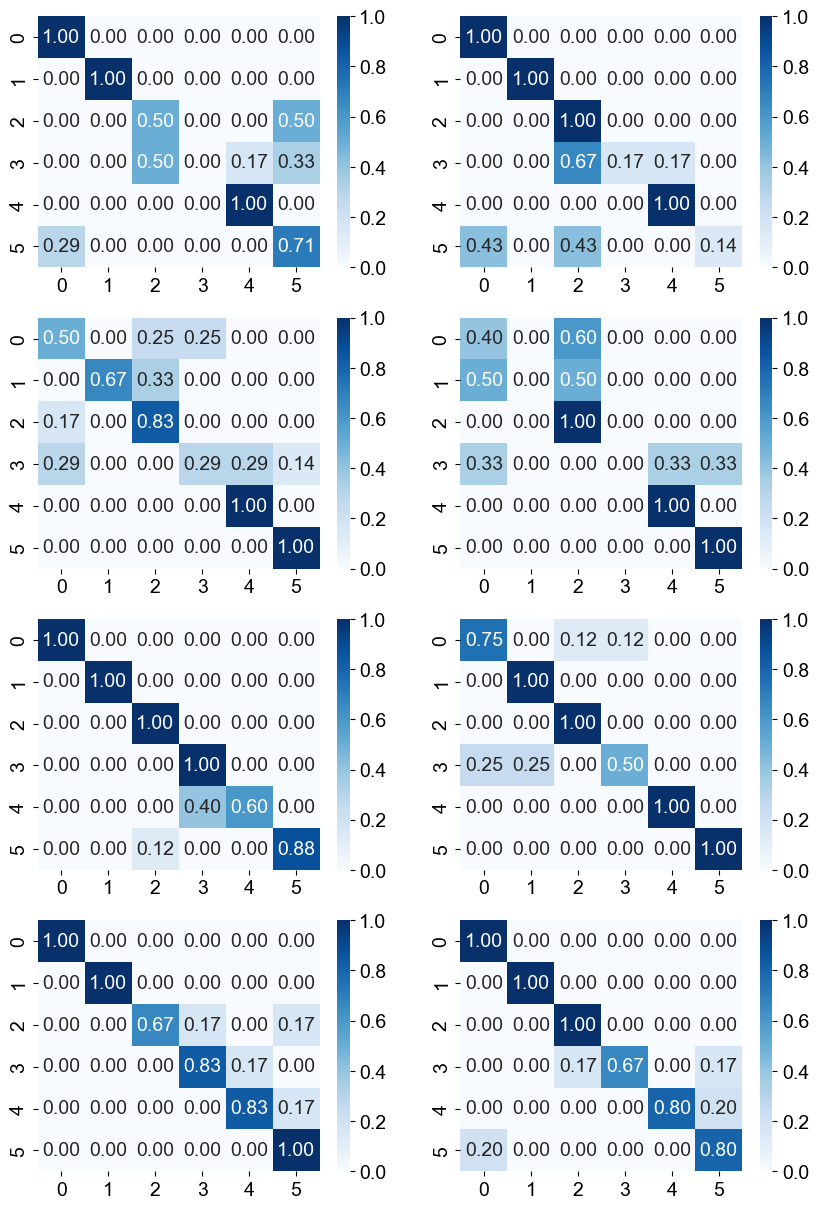

In [253]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

# pv_biased
loader = DataLoader(test_dataset_nirs_biased, batch_size=batch_size, shuffle=True)
predictions, labels = get_predictions_and_labels(model_gru_nirs_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('')

# pv_biased_bi
loader = DataLoader(test_dataset_nirs_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_nirs_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[0, 1])

# imu_biased
loader = DataLoader(test_dataset_imu_biased, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_imu_biased, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 0])

# imu_biased_bi
loader = DataLoader(test_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_imu_biased_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1, 1])

# mono
loader = DataLoader(test_dataset_mono, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_mono, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 0])

# mono_bi
loader = DataLoader(test_dataset_mono_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels(model_gru_mono_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[2, 1])

# dual
loader = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_gru_dual, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 0])

# dual_bi
loader = DataLoader(test_dataset_dual_bi, batch_size=batch_size, shuffle=False)
predictions, labels = get_predictions_and_labels_dual(model_gru_dual_bi, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[3, 1])

plt.savefig('../results/fig3/confusion_matrix_gru_test.png', dpi=600, bbox_inches='tight')

plt.show()


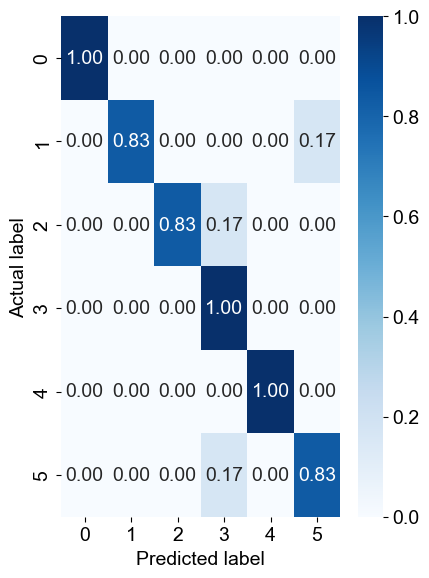

In [264]:
predictions, labels = get_predictions_and_labels_dual(model_gru_dual_bi, test_loader_dual)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(4.5, 6.5))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.savefig('../results/fig3/confusion_matrix_dual.png', dpi=600, bbox_inches='tight')
plt.show()